# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [87]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [88]:
azdias['PRAEGENDE_JUGENDJAHRE']

0          0
1         14
2         15
3          8
4          8
          ..
891216    14
891217    10
891218    14
891219    14
891220     3
Name: PRAEGENDE_JUGENDJAHRE, Length: 891221, dtype: int64

In [89]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [581]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head(2)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0


In [4]:
azdias.shape

(891221, 85)

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [13]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.shape

(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [45]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1.0,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.0,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1.0,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1.0,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [48]:

azdias.loc[azdias["AGER_TYP"].isin([-1, '0']), "AGER_TYP"] = np.nan

In [130]:
#azdias["AGER_TYP"] = np.where(azdias["AGER_TYP"].isin(['-1', '0'],azdias["AGER_TYP"]) = np.nan

azdias.tail()
# feat_info['attribute'].iloc[0]
#feat_info.loc[feat_info['attribute'] == 'AGER_TYP', 'missing_or_unknown'][0]
#np.nan

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,NaN,3.0,2.0,5.0,1.0,4.0,2.0,5.0,4.0,4.0,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,NaN,2.0,1.0,4.0,3.0,3.0,3.0,2.0,2.0,3.0,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,NaN,2.0,2.0,4.0,2.0,4.0,2.0,5.0,4.0,3.0,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,NaN,1.0,1.0,3.0,1.0,5.0,3.0,5.0,5.0,5.0,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,NaN,4.0,1.0,1.0,4.0,2.0,5.0,2.0,1.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [139]:
# val = feat_info.loc[feat_info['attribute'] == 'CAMEO_DEUG_2015', 'missing_or_unknown']
#print(val)
# val1 = convert_to_list(val[57])
# print(val1)
#(feat_info['attribute'][1] == 'ALTERSKATEGORIE_GROB')
azdias['OST_WEST_KZ'].isna()


0          True
1         False
2         False
3         False
4         False
          ...  
891216    False
891217    False
891218    False
891219    False
891220    False
Name: OST_WEST_KZ, Length: 891221, dtype: bool

In [118]:
# feat_info.loc[feat_info['attribute'] == 'ALTERSKATEGORIE_GROB', 'missing_or_unknown']
val = feat_info.loc[feat_info['attribute'] == 'ALTERSKATEGORIE_GROB', 'missing_or_unknown']
print(val[1])
val1 = convert_to_list(val[1])
print(val1)

[-1,0,9]
[-1, 0, 9]


In [157]:
def convert_to_list(input_val):
    result = []
    str_val = input_val.strip('][').split(',')
    for val in str_val:
        try:
            result.append(int(val))
        except:
            result.append(val)
    return result

def get_known_missing_value(colname, index):
    print('colname' + colname)
    string_value = feat_info.loc[feat_info['attribute'] == colname, 'missing_or_unknown'][index]
    if(string_value == '[]'):
        return []
    return convert_to_list(string_value)

In [158]:
# Identify missing or unknown data values and convert them to NaNs.
i = 0
#naturally_empty = []
for (index, colname) in enumerate(azdias):
    print(colname)
    missing_values = get_known_missing_value(colname, i)
    print(missing_values)
    azdias.loc[azdias[colname].isin(missing_values), colname] = np.nan
    i+=1
print(i)
#     print(index, azdias[colname])
#     print(get_known_missing_value(colname))
#     print(naturally_empty)
#     i+=1
#     if(i == 1):
#         break


AGER_TYP
colnameAGER_TYP
[-1, 0]
ALTERSKATEGORIE_GROB
colnameALTERSKATEGORIE_GROB
[-1, 0, 9]
ANREDE_KZ
colnameANREDE_KZ
[-1, 0]
CJT_GESAMTTYP
colnameCJT_GESAMTTYP
[0]
FINANZ_MINIMALIST
colnameFINANZ_MINIMALIST
[-1]
FINANZ_SPARER
colnameFINANZ_SPARER
[-1]
FINANZ_VORSORGER
colnameFINANZ_VORSORGER
[-1]
FINANZ_ANLEGER
colnameFINANZ_ANLEGER
[-1]
FINANZ_UNAUFFAELLIGER
colnameFINANZ_UNAUFFAELLIGER
[-1]
FINANZ_HAUSBAUER
colnameFINANZ_HAUSBAUER
[-1]
FINANZTYP
colnameFINANZTYP
[-1]
GEBURTSJAHR
colnameGEBURTSJAHR
[0]
GFK_URLAUBERTYP
colnameGFK_URLAUBERTYP
[]
GREEN_AVANTGARDE
colnameGREEN_AVANTGARDE
[]
HEALTH_TYP
colnameHEALTH_TYP
[-1, 0]
LP_LEBENSPHASE_FEIN
colnameLP_LEBENSPHASE_FEIN
[0]
LP_LEBENSPHASE_GROB
colnameLP_LEBENSPHASE_GROB
[0]
LP_FAMILIE_FEIN
colnameLP_FAMILIE_FEIN
[0]
LP_FAMILIE_GROB
colnameLP_FAMILIE_GROB
[0]
LP_STATUS_FEIN
colnameLP_STATUS_FEIN
[0]
LP_STATUS_GROB
colnameLP_STATUS_GROB
[0]
NATIONALITAET_KZ
colnameNATIONALITAET_KZ
[-1, 0]
PRAEGENDE_JUGENDJAHRE
colnamePRAEGENDE_JUGENDJ

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [159]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# ALTERSKATEGORIE_GROB
notnull_info =[]
for (index, colname) in enumerate(azdias):
    notnull_info.append({'name': colname, 'missing':azdias[colname].isna().sum(), 'percentage': (azdias[colname].isna().sum()/len(azdias))*100})
                
for row in range(len(notnull_info)):
    print(notnull_info[row])
    


{'name': 'AGER_TYP', 'missing': 685843, 'percentage': 76.95543529607134}
{'name': 'ALTERSKATEGORIE_GROB', 'missing': 2881, 'percentage': 0.32326437550282144}
{'name': 'ANREDE_KZ', 'missing': 0, 'percentage': 0.0}
{'name': 'CJT_GESAMTTYP', 'missing': 4854, 'percentage': 0.5446460529992}
{'name': 'FINANZ_MINIMALIST', 'missing': 0, 'percentage': 0.0}
{'name': 'FINANZ_SPARER', 'missing': 0, 'percentage': 0.0}
{'name': 'FINANZ_VORSORGER', 'missing': 0, 'percentage': 0.0}
{'name': 'FINANZ_ANLEGER', 'missing': 0, 'percentage': 0.0}
{'name': 'FINANZ_UNAUFFAELLIGER', 'missing': 0, 'percentage': 0.0}
{'name': 'FINANZ_HAUSBAUER', 'missing': 0, 'percentage': 0.0}
{'name': 'FINANZTYP', 'missing': 0, 'percentage': 0.0}
{'name': 'GEBURTSJAHR', 'missing': 392318, 'percentage': 44.02028228688507}
{'name': 'GFK_URLAUBERTYP', 'missing': 4854, 'percentage': 0.5446460529992}
{'name': 'GREEN_AVANTGARDE', 'missing': 0, 'percentage': 0.0}
{'name': 'HEALTH_TYP', 'missing': 111196, 'percentage': 12.476815514894

In [160]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               205378 non-null  float64
 1   ALTERSKATEGORIE_GROB   888340 non-null  float64
 2   ANREDE_KZ              891221 non-null  float64
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  float64
 5   FINANZ_SPARER          891221 non-null  float64
 6   FINANZ_VORSORGER       891221 non-null  float64
 7   FINANZ_ANLEGER         891221 non-null  float64
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  float64
 9   FINANZ_HAUSBAUER       891221 non-null  float64
 10  FINANZTYP              891221 non-null  float64
 11  GEBURTSJAHR            498903 non-null  float64
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  float64
 14  HEALTH_TYP             780025 non-nu

In [142]:
azdias.isnull().sum().sum()

8373929

In [154]:
azdias['AGER_TYP']

0         NaN
1         NaN
2         NaN
3         2.0
4         NaN
         ... 
891216    NaN
891217    NaN
891218    NaN
891219    NaN
891220    NaN
Name: AGER_TYP, Length: 891221, dtype: float64

C:\Users\M1053229\AppData\Local\Temp\ipykernel_21412\3082319135.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


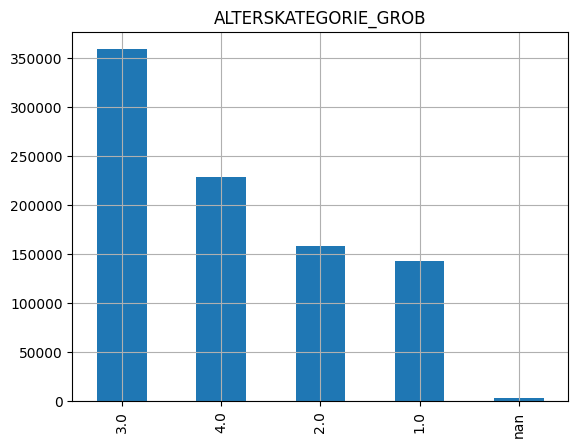

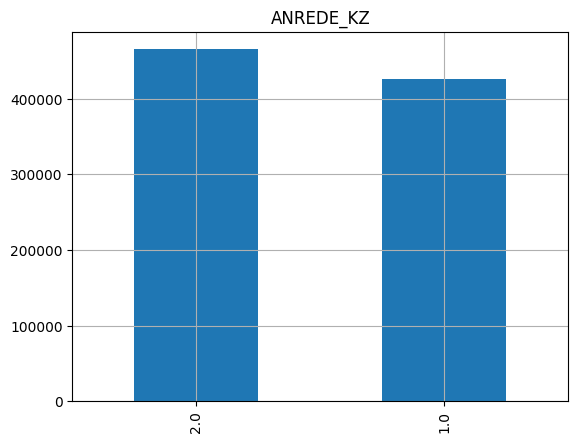

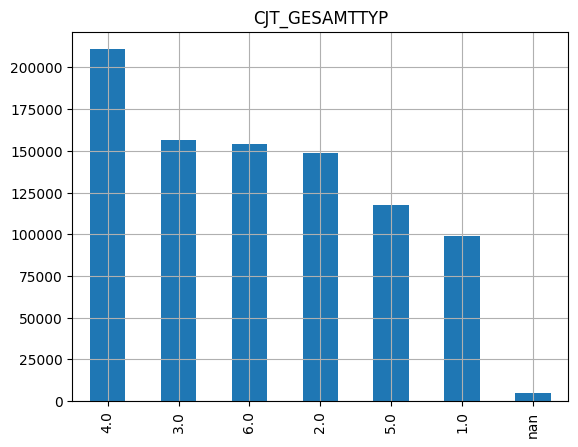

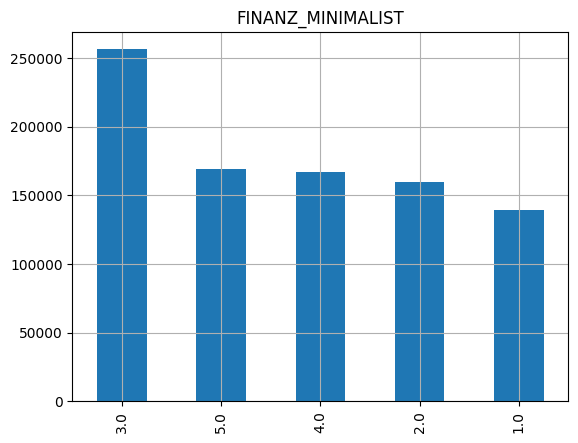

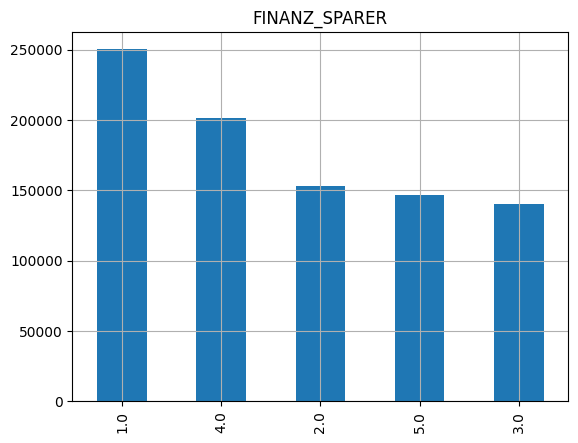

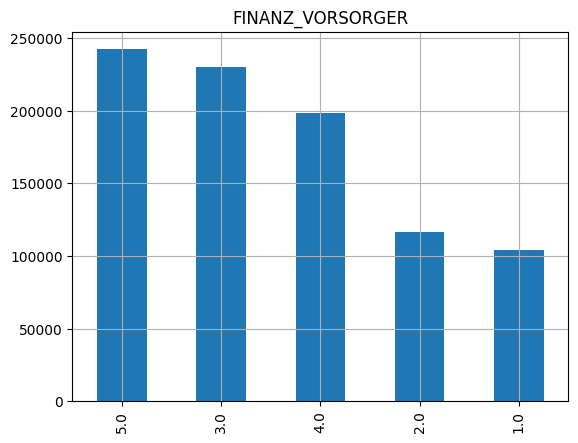

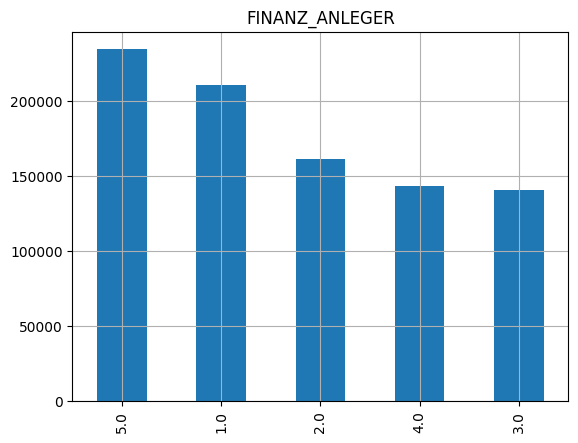

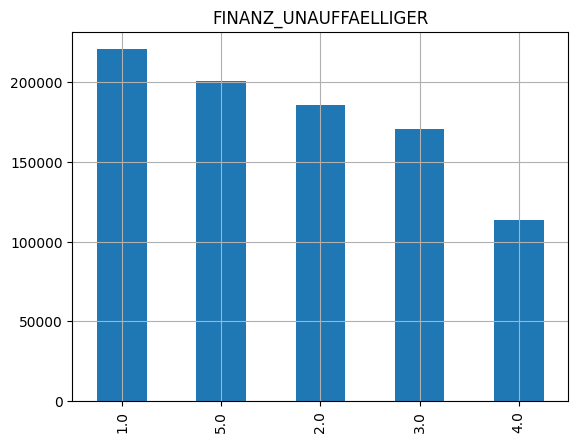

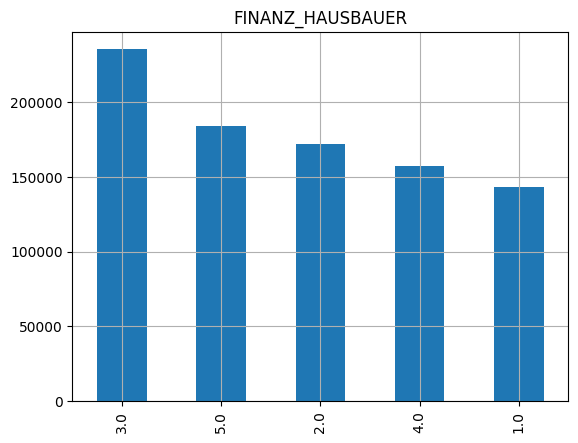

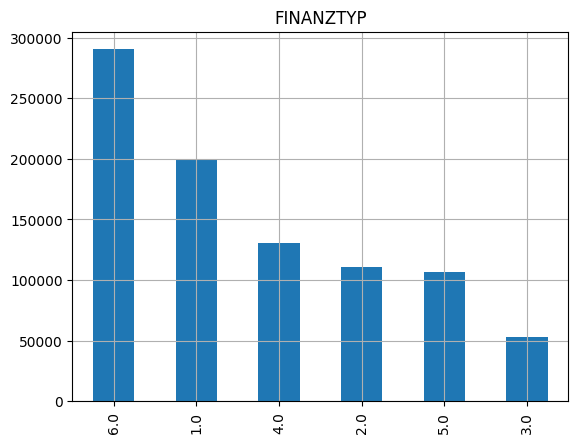

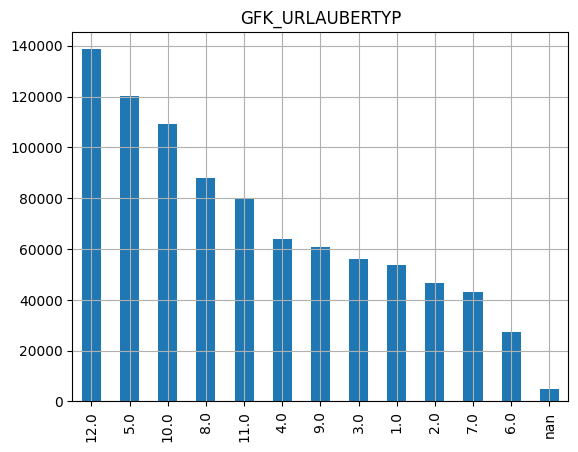

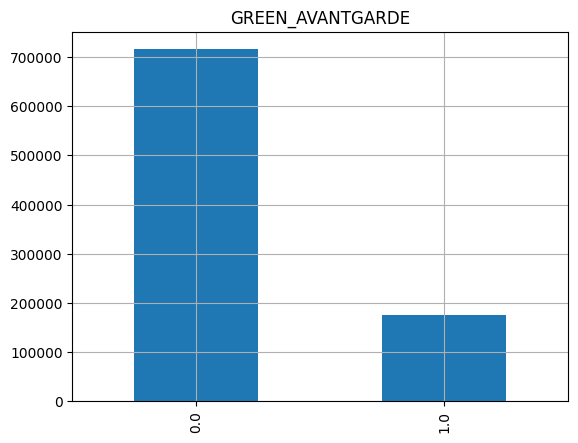

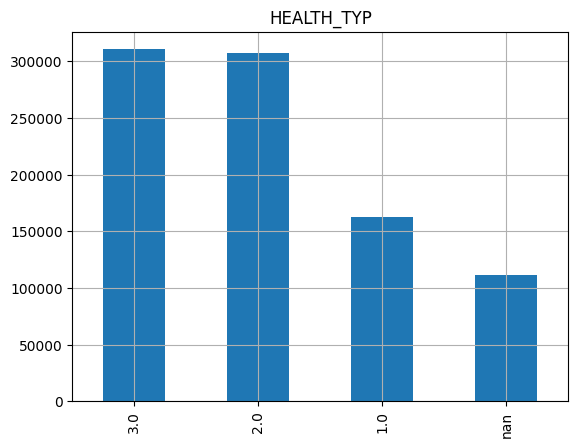

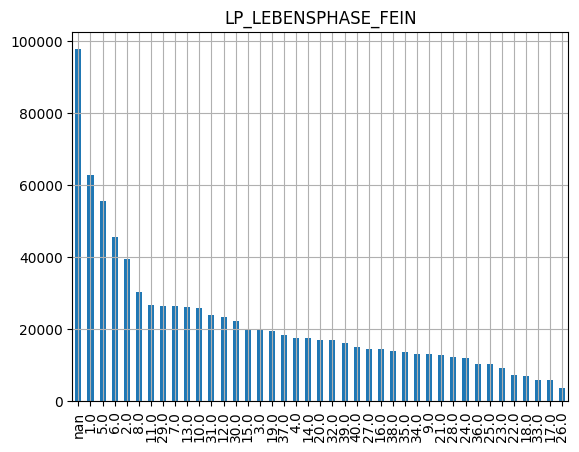

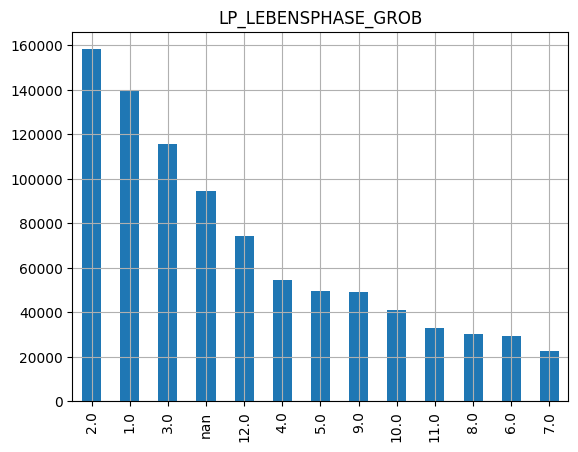

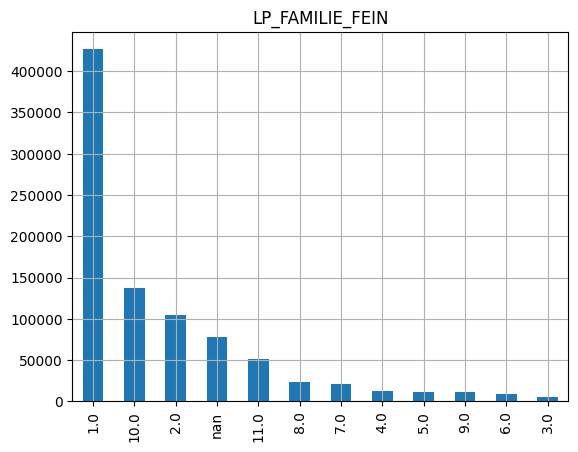

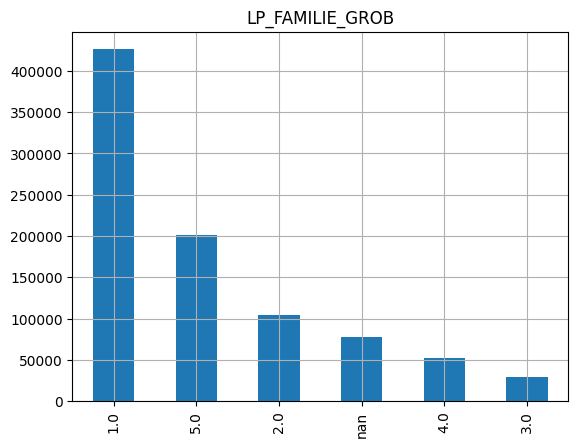

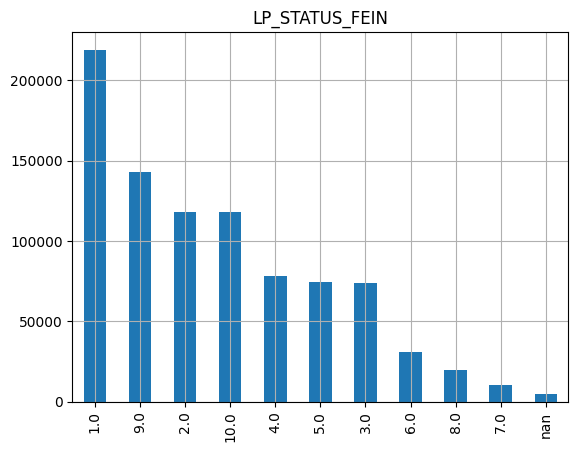

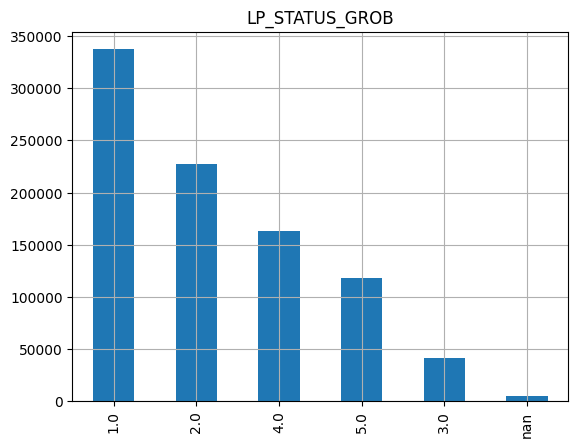

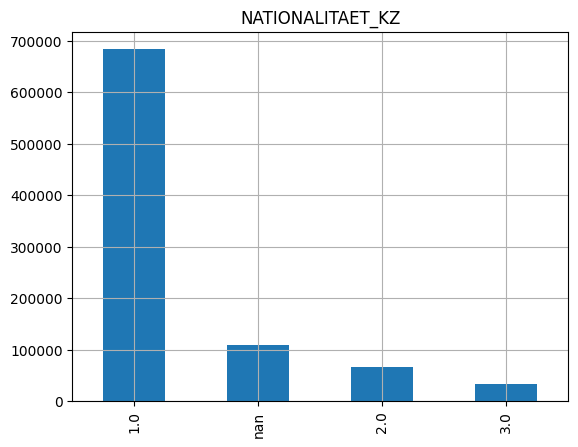

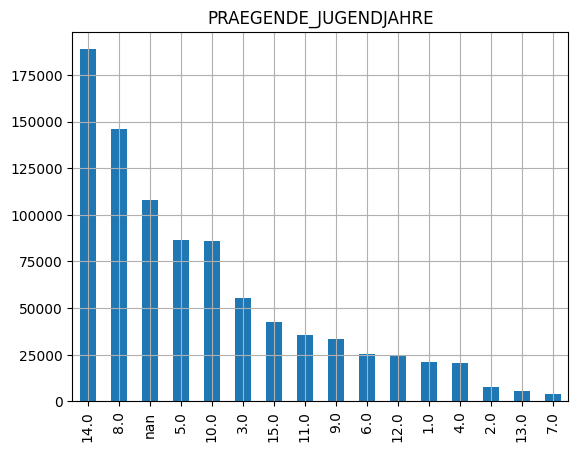

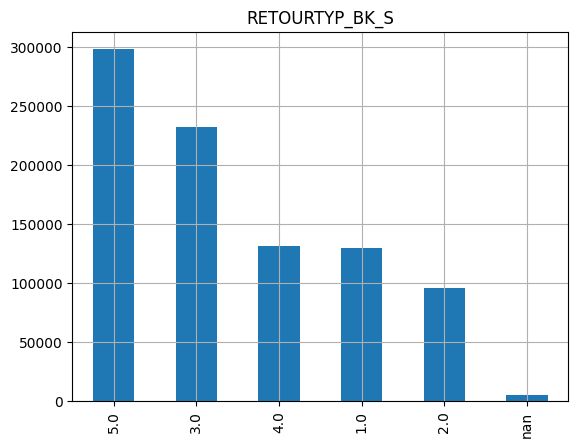

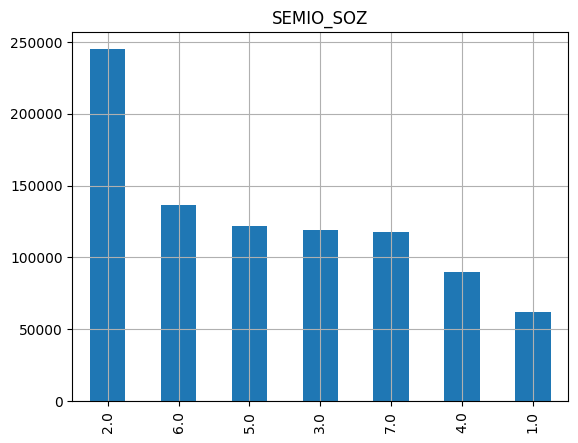

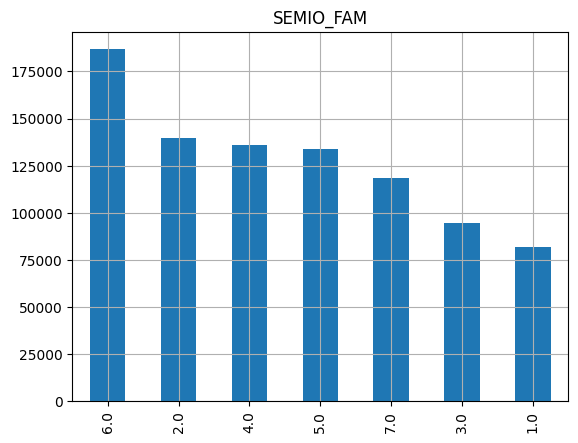

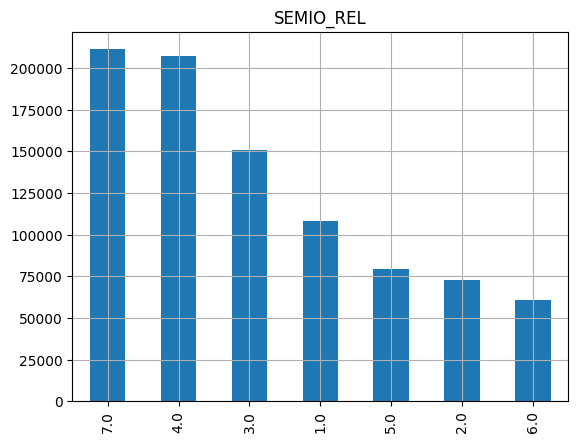

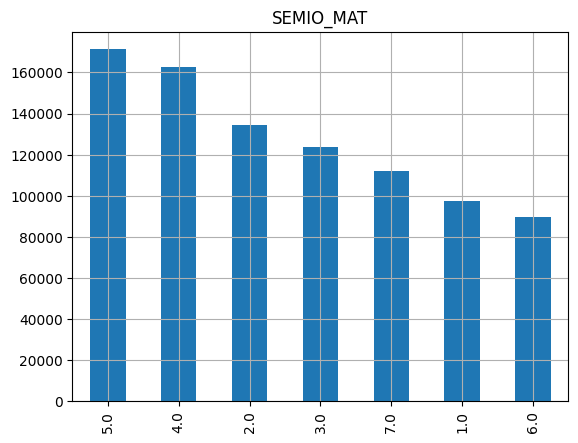

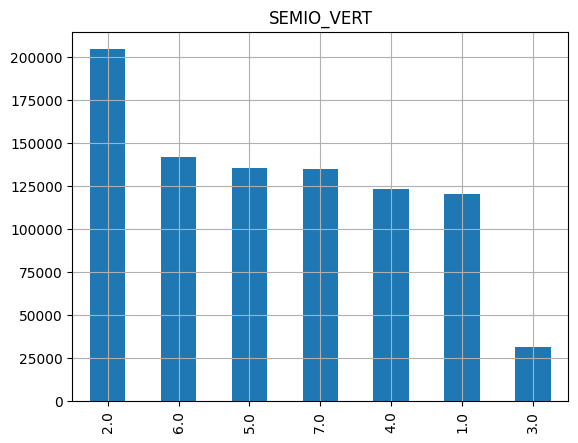

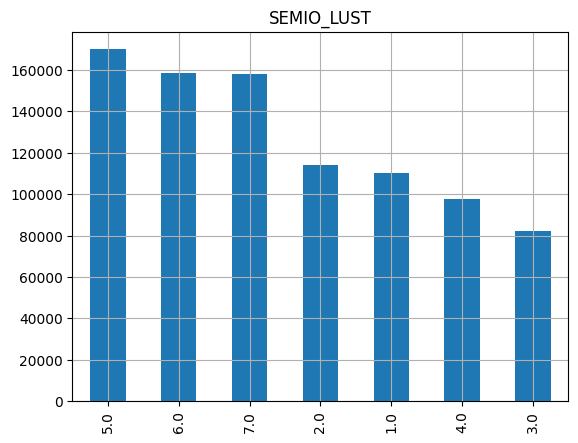

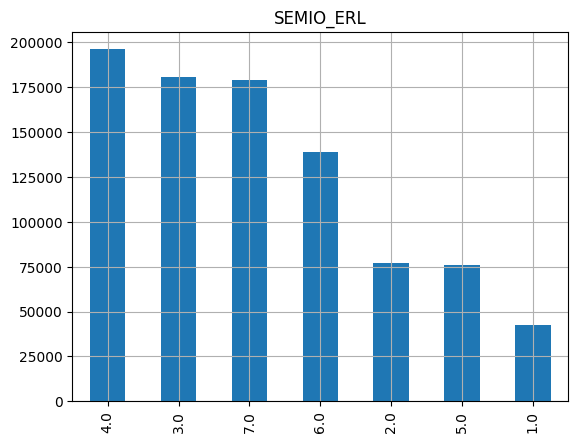

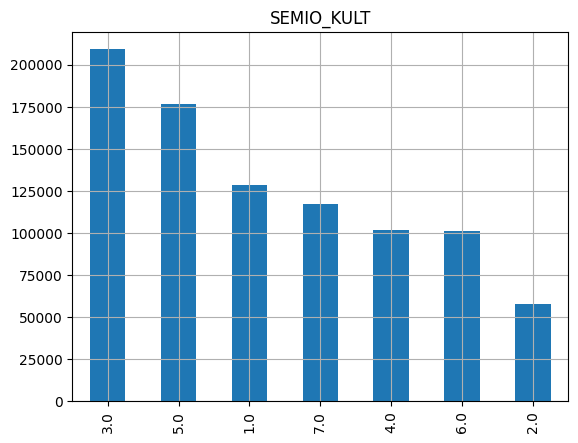

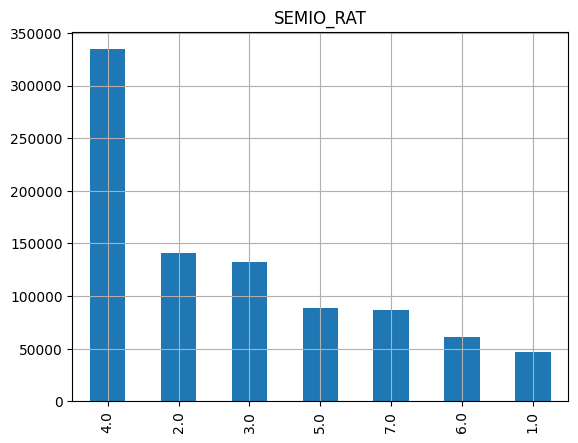

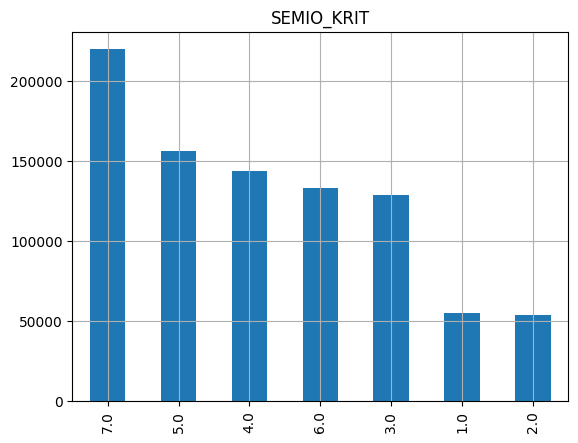

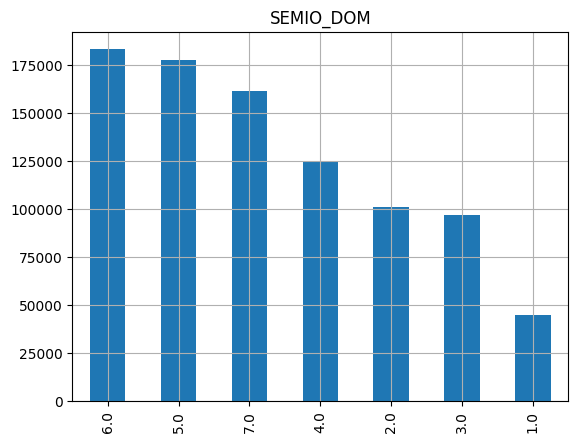

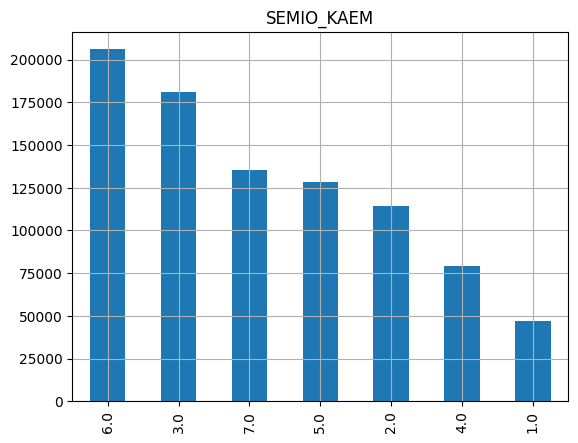

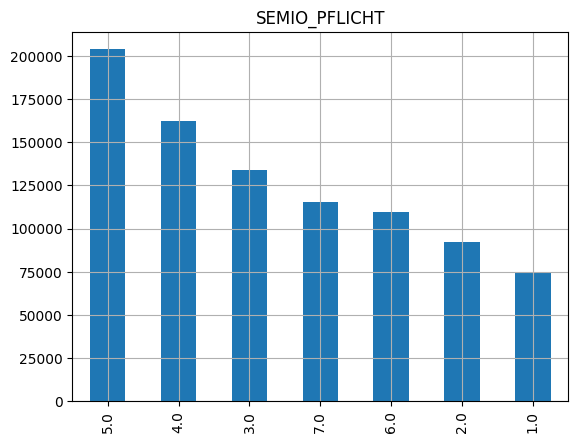

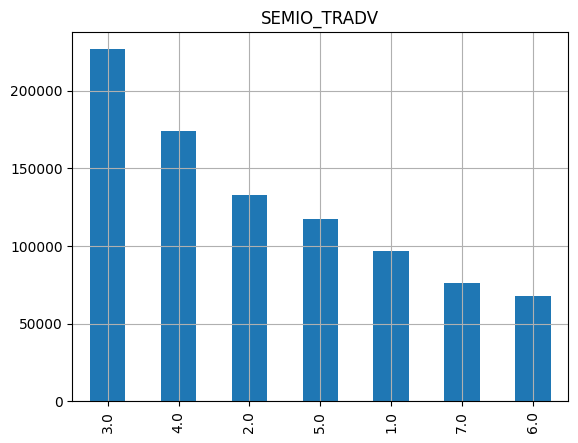

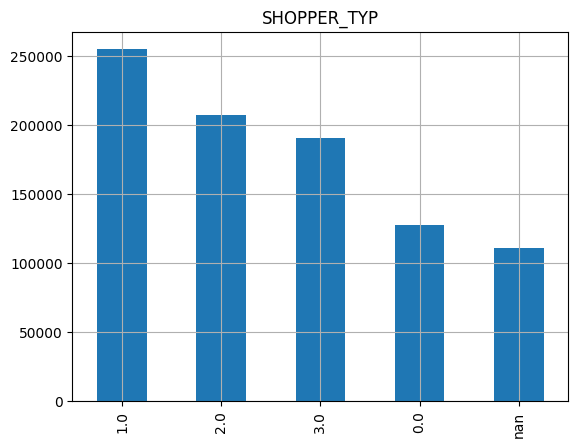

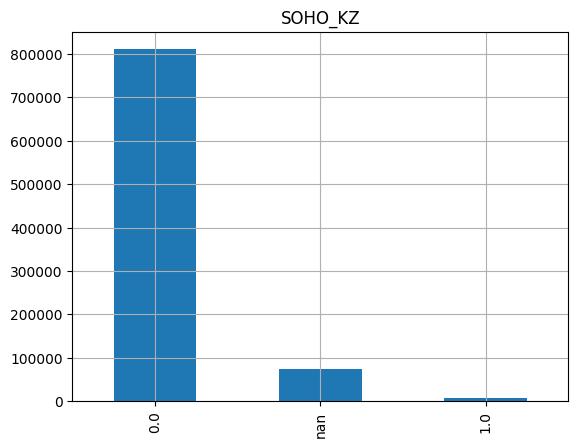

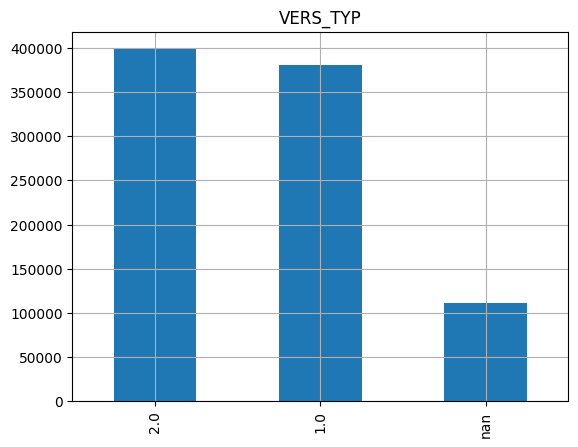

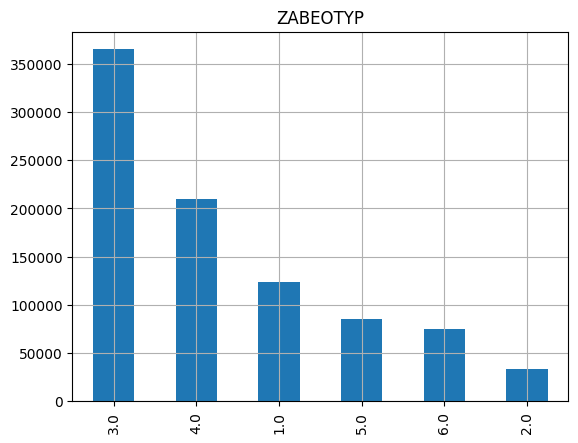

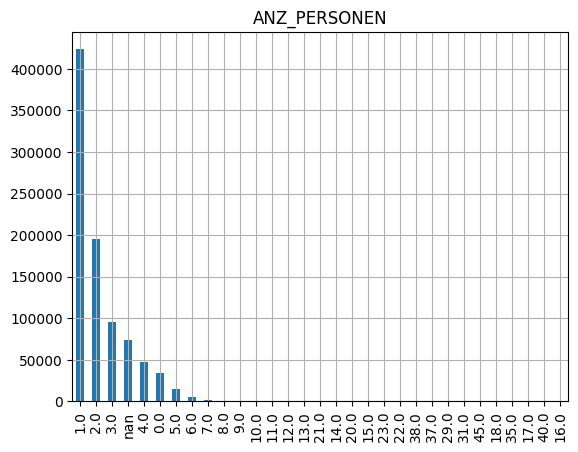

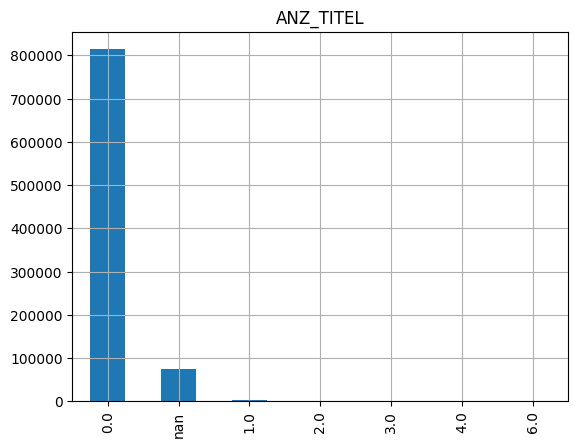

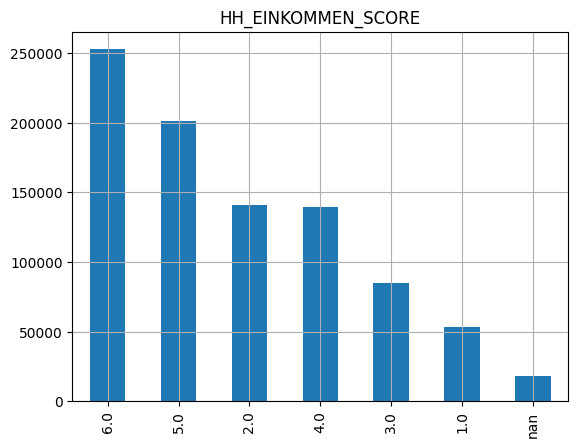

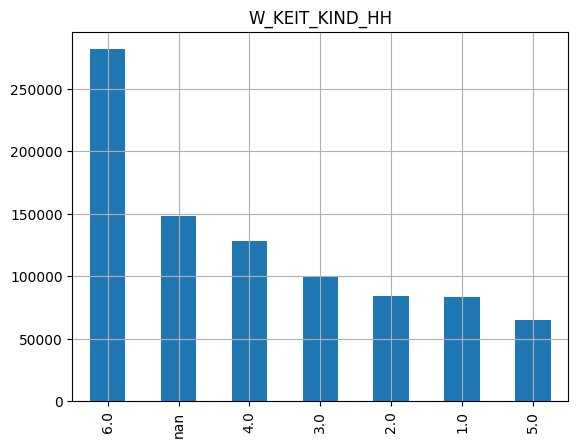

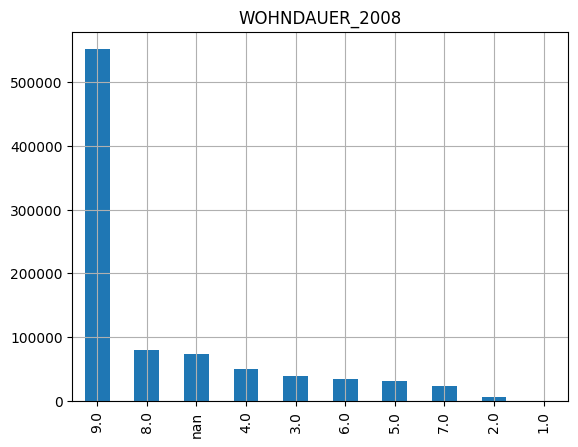

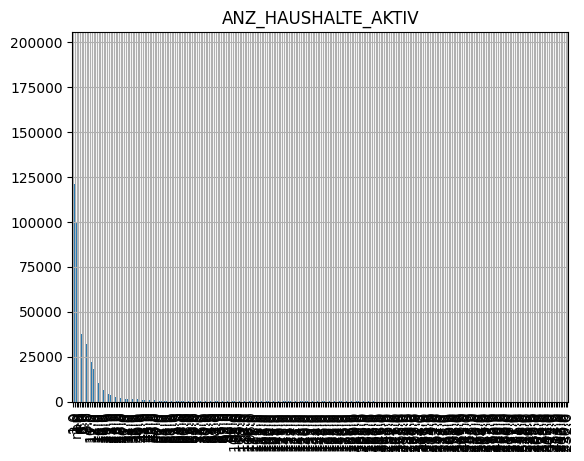

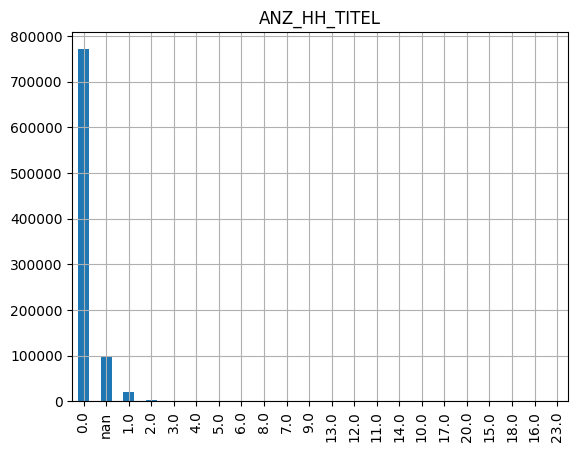

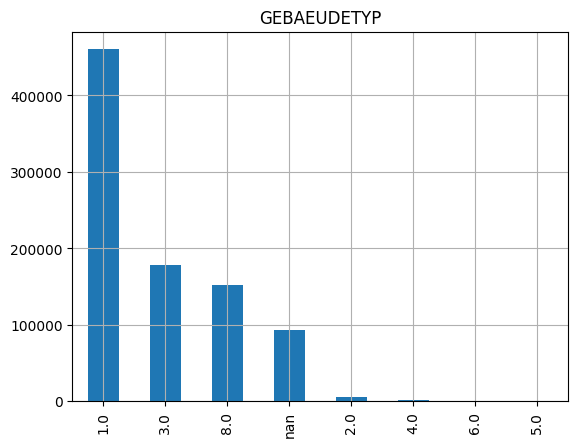

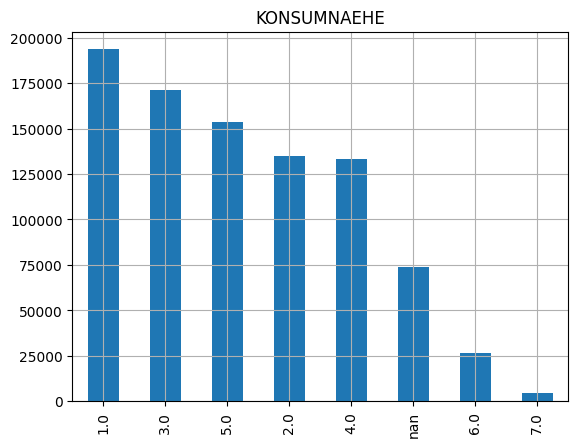

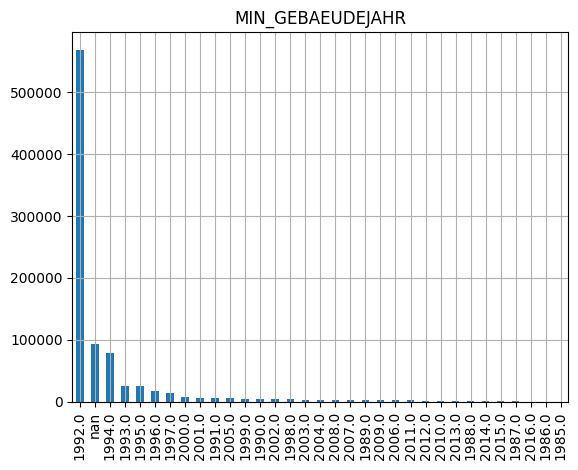

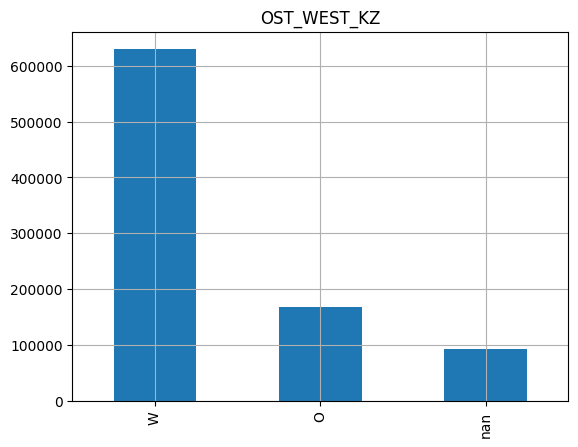

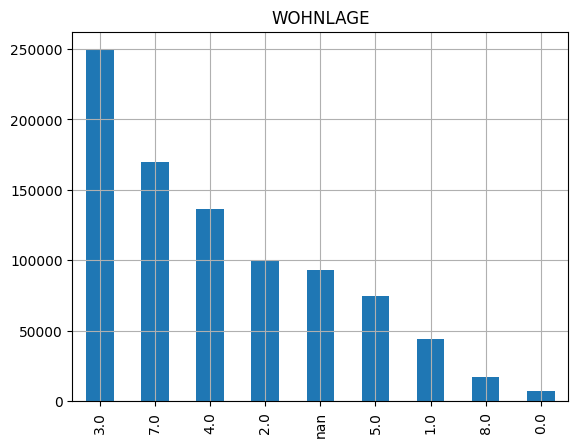

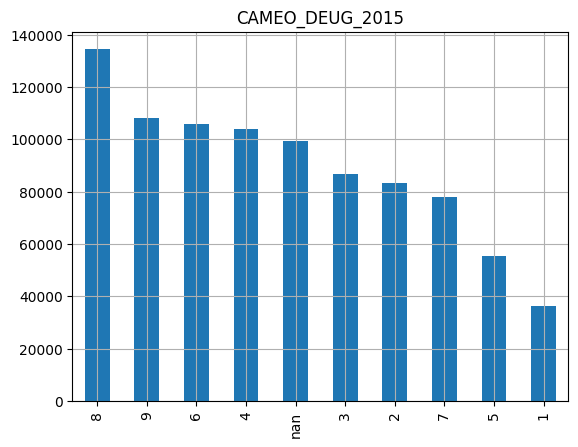

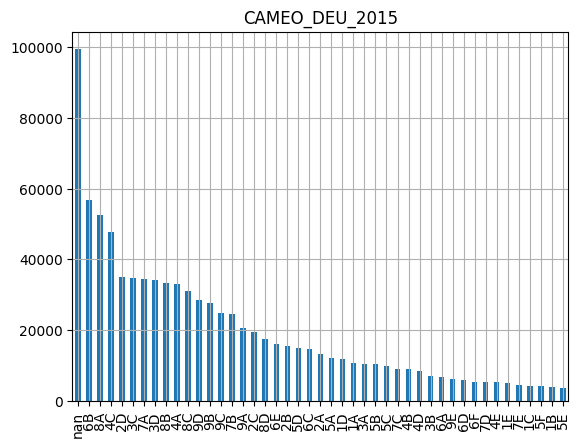

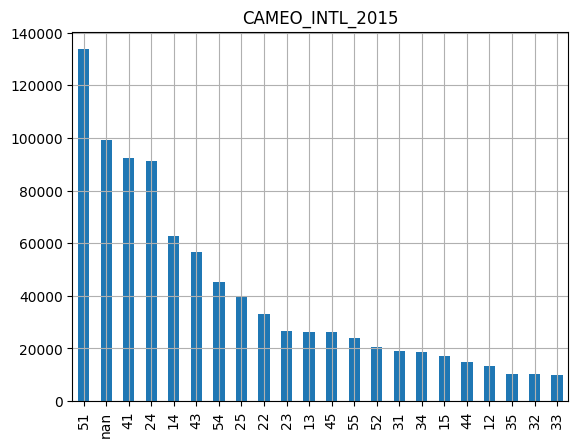

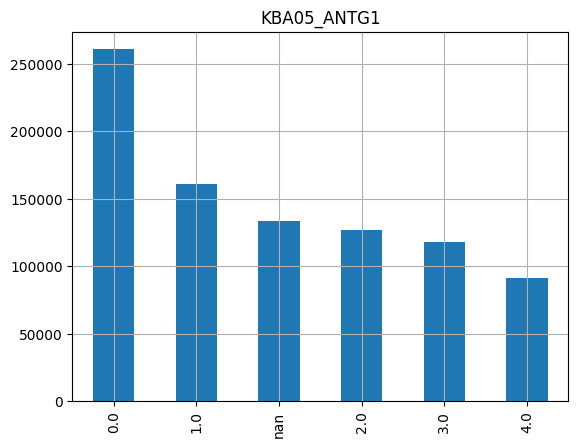

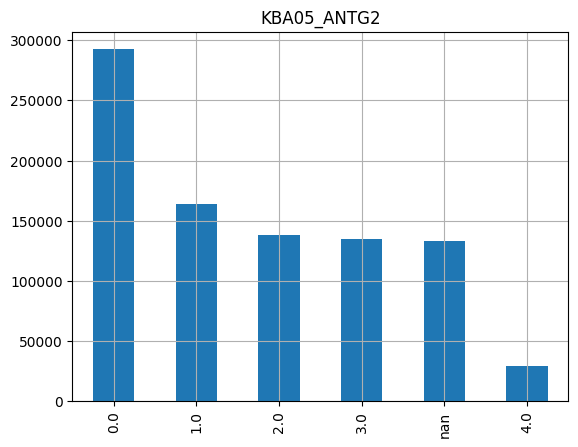

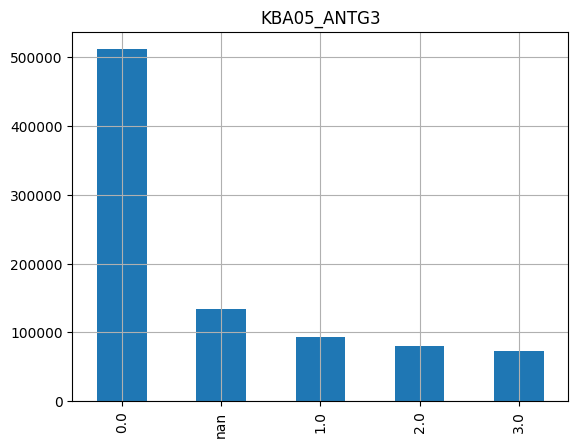

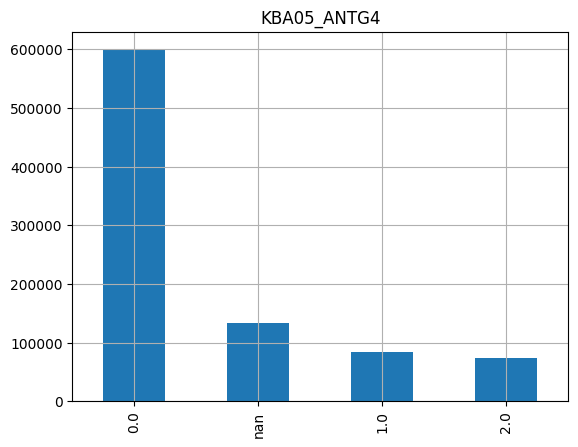

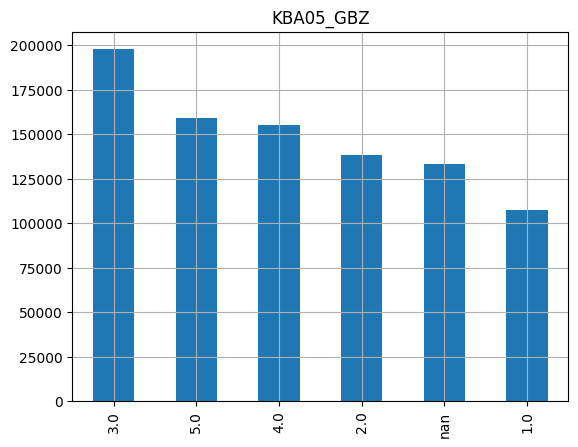

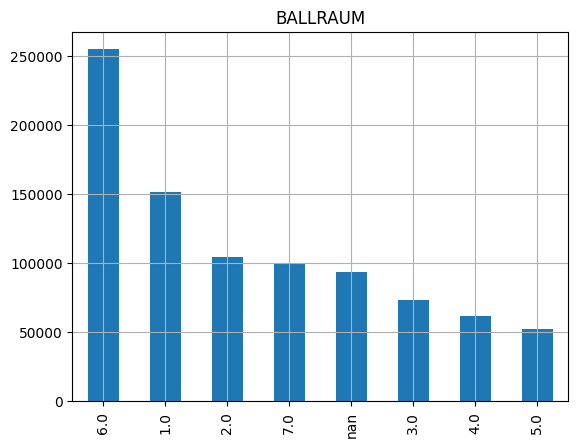

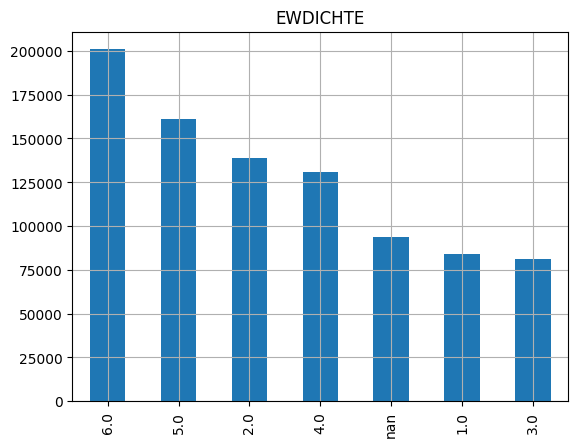

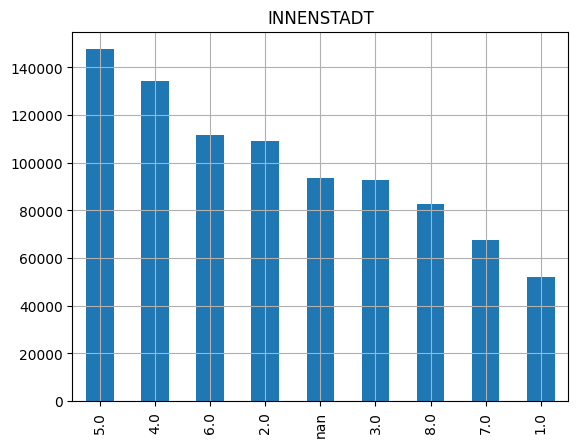

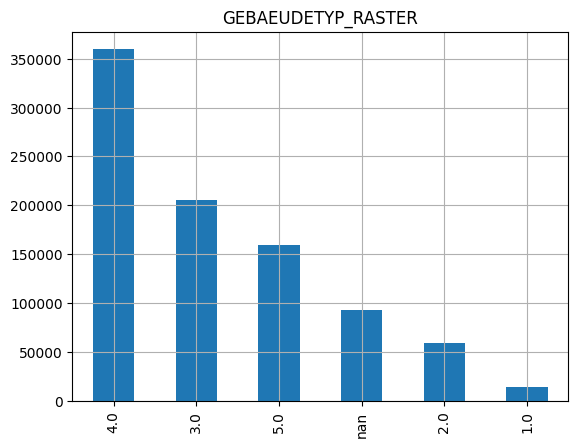

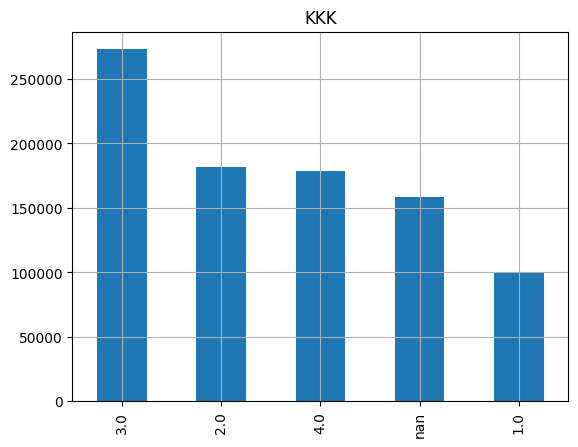

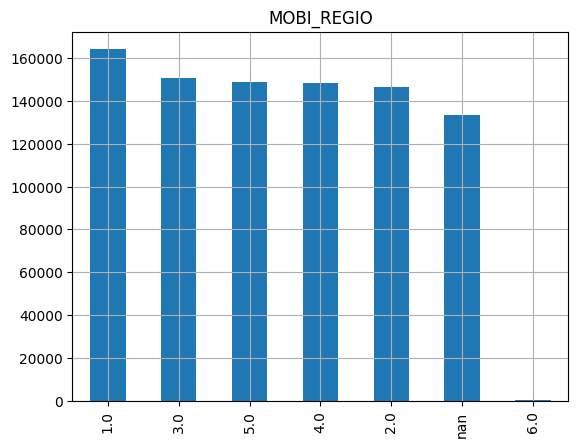

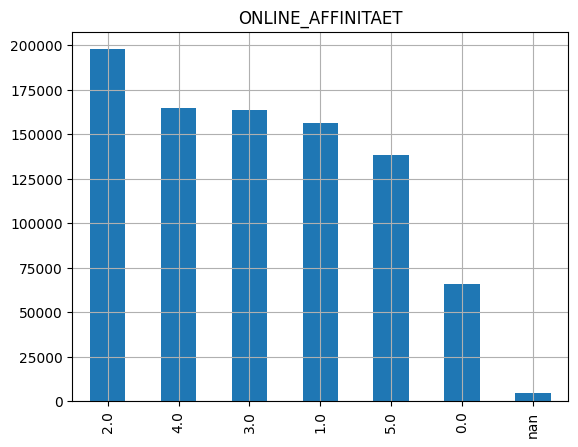

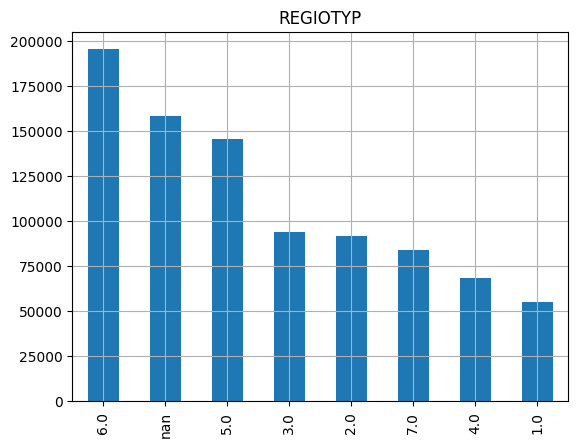

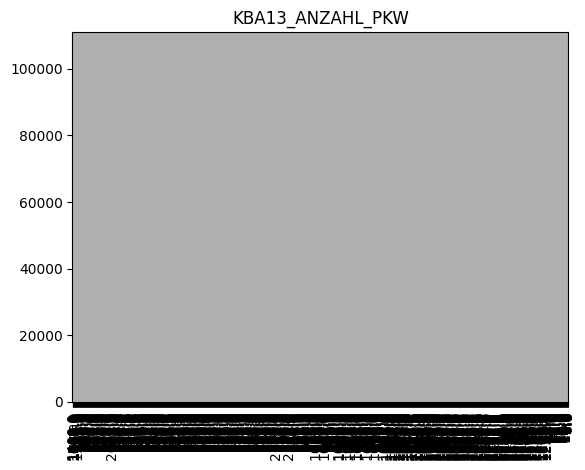

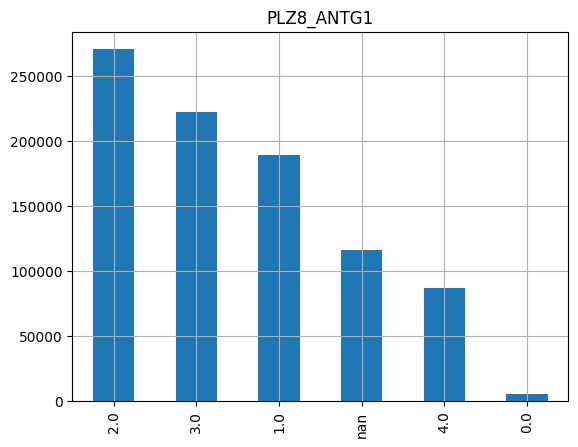

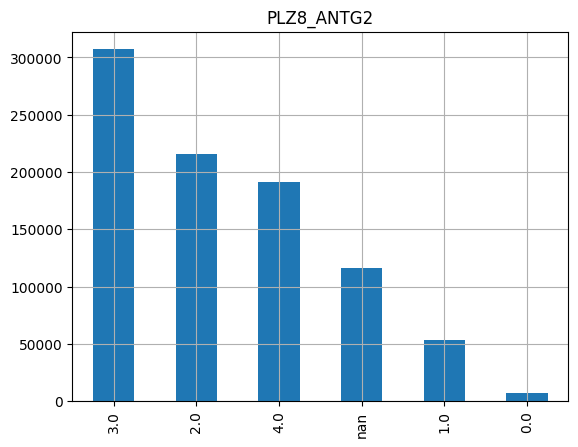

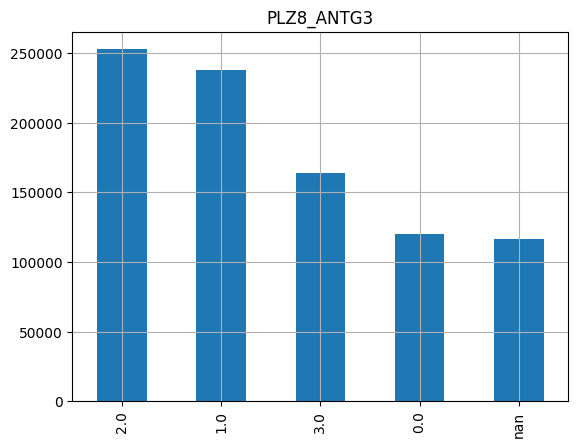

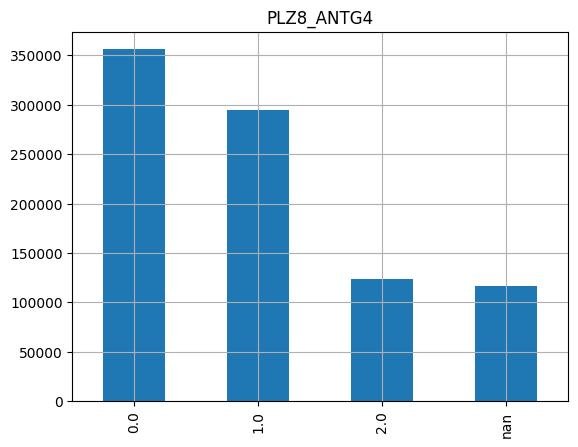

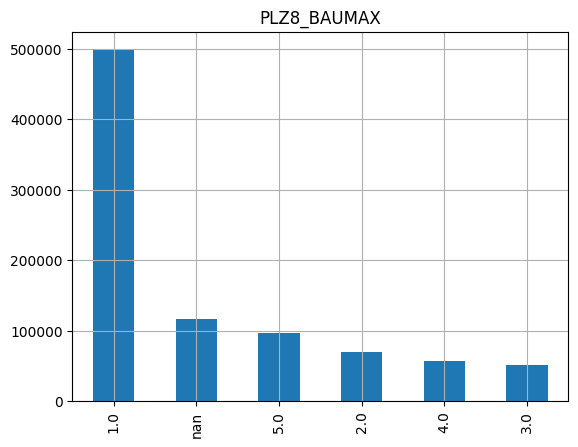

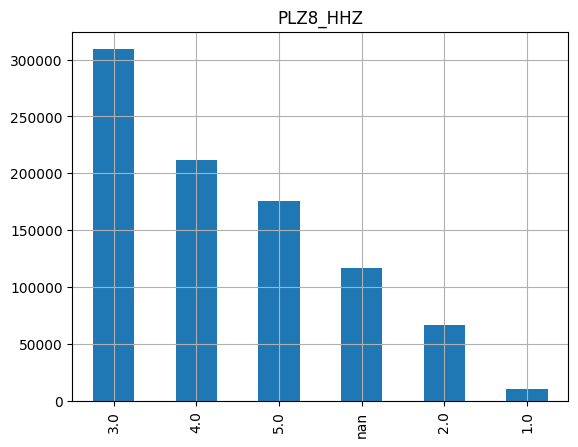

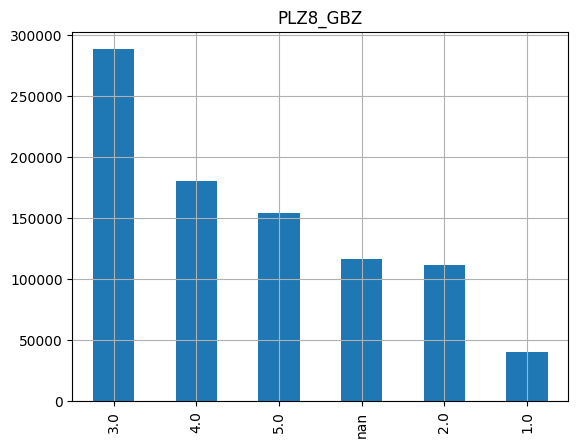

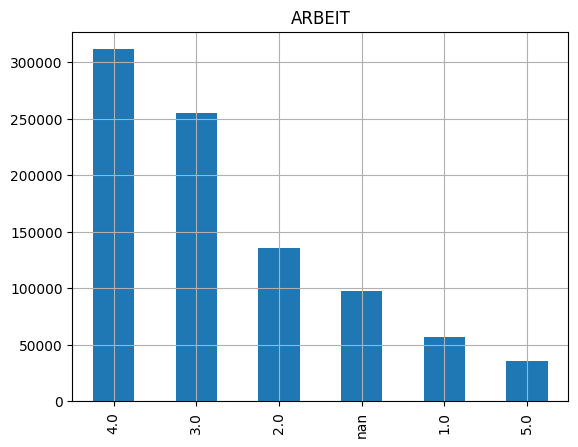

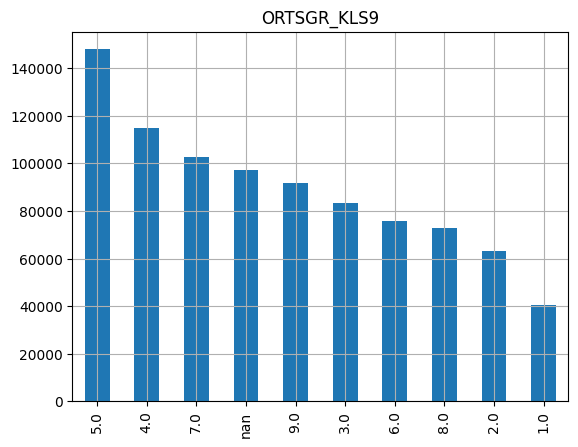

In [251]:
# Investigate patterns in the amount of missing data in each column.
from numpy import nan
for (index, colname) in enumerate(azdias):
    plt.figure()
    counts = azdias[colname].value_counts(dropna=False)
    counts.plot.bar(title=colname, grid=True)
plt.close()


In [176]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
from operator import itemgetter
newlist = sorted(notnull_info, key=itemgetter('percentage'), reverse=True)


[{'name': 'TITEL_KZ', 'missing': 889061, 'percentage': 99.75763587258379},
 {'name': 'AGER_TYP', 'missing': 685843, 'percentage': 76.95543529607134},
 {'name': 'KK_KUNDENTYP', 'missing': 584612, 'percentage': 65.59674873011295},
 {'name': 'KBA05_BAUMAX', 'missing': 476524, 'percentage': 53.468668265222654},
 {'name': 'GEBURTSJAHR', 'missing': 392318, 'percentage': 44.02028228688507},
 {'name': 'ALTER_HH', 'missing': 310267, 'percentage': 34.81369940789097},
 {'name': 'KKK', 'missing': 158064, 'percentage': 17.73566825736826},
 {'name': 'REGIOTYP', 'missing': 158064, 'percentage': 17.73566825736826},
 {'name': 'W_KEIT_KIND_HH',
  'missing': 147988,
  'percentage': 16.60508448521747},
 {'name': 'KBA05_ANTG1', 'missing': 133324, 'percentage': 14.959701353536328},
 {'name': 'KBA05_ANTG2', 'missing': 133324, 'percentage': 14.959701353536328},
 {'name': 'KBA05_ANTG3', 'missing': 133324, 'percentage': 14.959701353536328},
 {'name': 'KBA05_ANTG4', 'missing': 133324, 'percentage': 14.9597013535

In [244]:
#Identify patterns
# feat_info.head()
# (feat_info['attribute'] == "AGER_TYP")

#string_value4, s5 = feat_info.loc[feat_info['attribute'] == "AGER_TYP", 'information_level', "missing_or_unknown"][0]
#string_value3 = feat_info.loc[feat_info['attribute'] == colname, 'missing_or_unknown'][0]
print(string_value)
print(string_value2)
missing_patterns_list = []
i = 0
for row in range(len(notnull_info)):
    row_details = notnull_info[row] 
    cat_type = feat_info.loc[feat_info['attribute'] == row_details['name'], 'type'][i]
    info = feat_info.loc[feat_info['attribute'] == row_details['name'], 'information_level'][i]
    missing_patterns_list.append({'column': row_details['name'],'category': cat_type, "information": info, 'percentage': round(row_details['percentage'],2)})
    i+=1
newlist = sorted(missing_patterns_list, key=itemgetter('percentage'), reverse=True)
for row in range(len(newlist)):
    print(newlist[row])


[-1,0]
person
{'column': 'TITEL_KZ', 'category': 'categorical', 'information': 'person', 'percentage': 99.76}
{'column': 'AGER_TYP', 'category': 'categorical', 'information': 'person', 'percentage': 76.96}
{'column': 'KK_KUNDENTYP', 'category': 'categorical', 'information': 'household', 'percentage': 65.6}
{'column': 'KBA05_BAUMAX', 'category': 'mixed', 'information': 'microcell_rr3', 'percentage': 53.47}
{'column': 'GEBURTSJAHR', 'category': 'numeric', 'information': 'person', 'percentage': 44.02}
{'column': 'ALTER_HH', 'category': 'interval', 'information': 'household', 'percentage': 34.81}
{'column': 'KKK', 'category': 'ordinal', 'information': 'region_rr1', 'percentage': 17.74}
{'column': 'REGIOTYP', 'category': 'ordinal', 'information': 'region_rr1', 'percentage': 17.74}
{'column': 'W_KEIT_KIND_HH', 'category': 'ordinal', 'information': 'household', 'percentage': 16.61}
{'column': 'KBA05_ANTG1', 'category': 'ordinal', 'information': 'microcell_rr3', 'percentage': 14.96}
{'column':

In [582]:
# #whole dict  

# #ind
# for row in range(1):
#     print(zip(*newlist[row].items()))
#     names, counts = zip(*newlist[row].items())
#     plt.bar(names, counts)
# sns.barplot(list(newlist[0].keys()), list(newlist[0].values()))
# pd.DataFrame(newlist[0], index=['percentage']).plot(kind='bar')
azdias = azdias.drop(["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"], axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column


Based on the Given data I can see that 20% data is not lost and around 5% of the data are missing more than 50% of the data. As I am new into ML I considered anything which has missing percentage in double digits is invalid but that seems to be we end up in removing considerable amount of data. so, I am considering the one from 34% where all the others has the maximum missing values as 17% max.

On the above we can consider the type person, household (also microcell_rr3) and seggregated as categorical, mixed, numerical.

The columns we will be removing will be TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [583]:
# How much data is missing in each row of the dataset?
# azdias.isna().sum(axis=1)[0:100].plot(kind='bar')
total_na_per_row = azdias.isna().sum(axis=1).sort_values(ascending=0)
print(total_na_per_row)
print((azdias.isna().sum(axis=1)).mean())


15284     44
469054    43
413815    43
180379    43
629707    43
          ..
332941     0
332942     0
332943     0
332944     0
891220     0
Length: 891221, dtype: int64
4.5240226610459136


In [584]:
azdias.isna().sum(axis=1).sort_values(ascending=0)
# get the rows that are more than 50% missing values
result = azdias.loc[azdias.isna().sum(axis=1) > 42]


In [585]:
azdias.drop(azdias[azdias.isna().sum(axis=1)> 42].index, inplace=True)

In [586]:
azdias

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3,2,5.0,1,4,2,5,4,4,1,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2,1,4.0,3,3,3,2,2,3,6,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2,2,4.0,2,4,2,5,4,3,1,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1,1,3.0,1,5,3,5,5,5,1,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [574]:
azdias

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestyle
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0.0,90.0,51,51
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,1.0,4.0,4.0,3.0,5.0,2.0,1.0,90.0,24,24
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,1.0,3.0,4.0,2.0,3.0,3.0,0.0,70.0,12,12
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0.0,70.0,43,43
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0.0,50.0,54,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2.0,5.0,1.0,4.0,2.0,5.0,4.0,4.0,1.0,...,1.0,2.0,3.0,NaN,NaN,NaN,0.0,90.0,41,41
891217,2.0,1.0,4.0,3.0,3.0,3.0,2.0,2.0,3.0,6.0,...,4.0,5.0,3.0,4.0,6.0,5.0,0.0,80.0,51,51
891218,2.0,2.0,4.0,2.0,4.0,2.0,5.0,4.0,3.0,1.0,...,1.0,3.0,4.0,2.0,2.0,3.0,0.0,90.0,24,24
891219,1.0,1.0,3.0,1.0,5.0,3.0,5.0,5.0,5.0,1.0,...,5.0,1.0,1.0,4.0,7.0,5.0,0.0,90.0,51,51


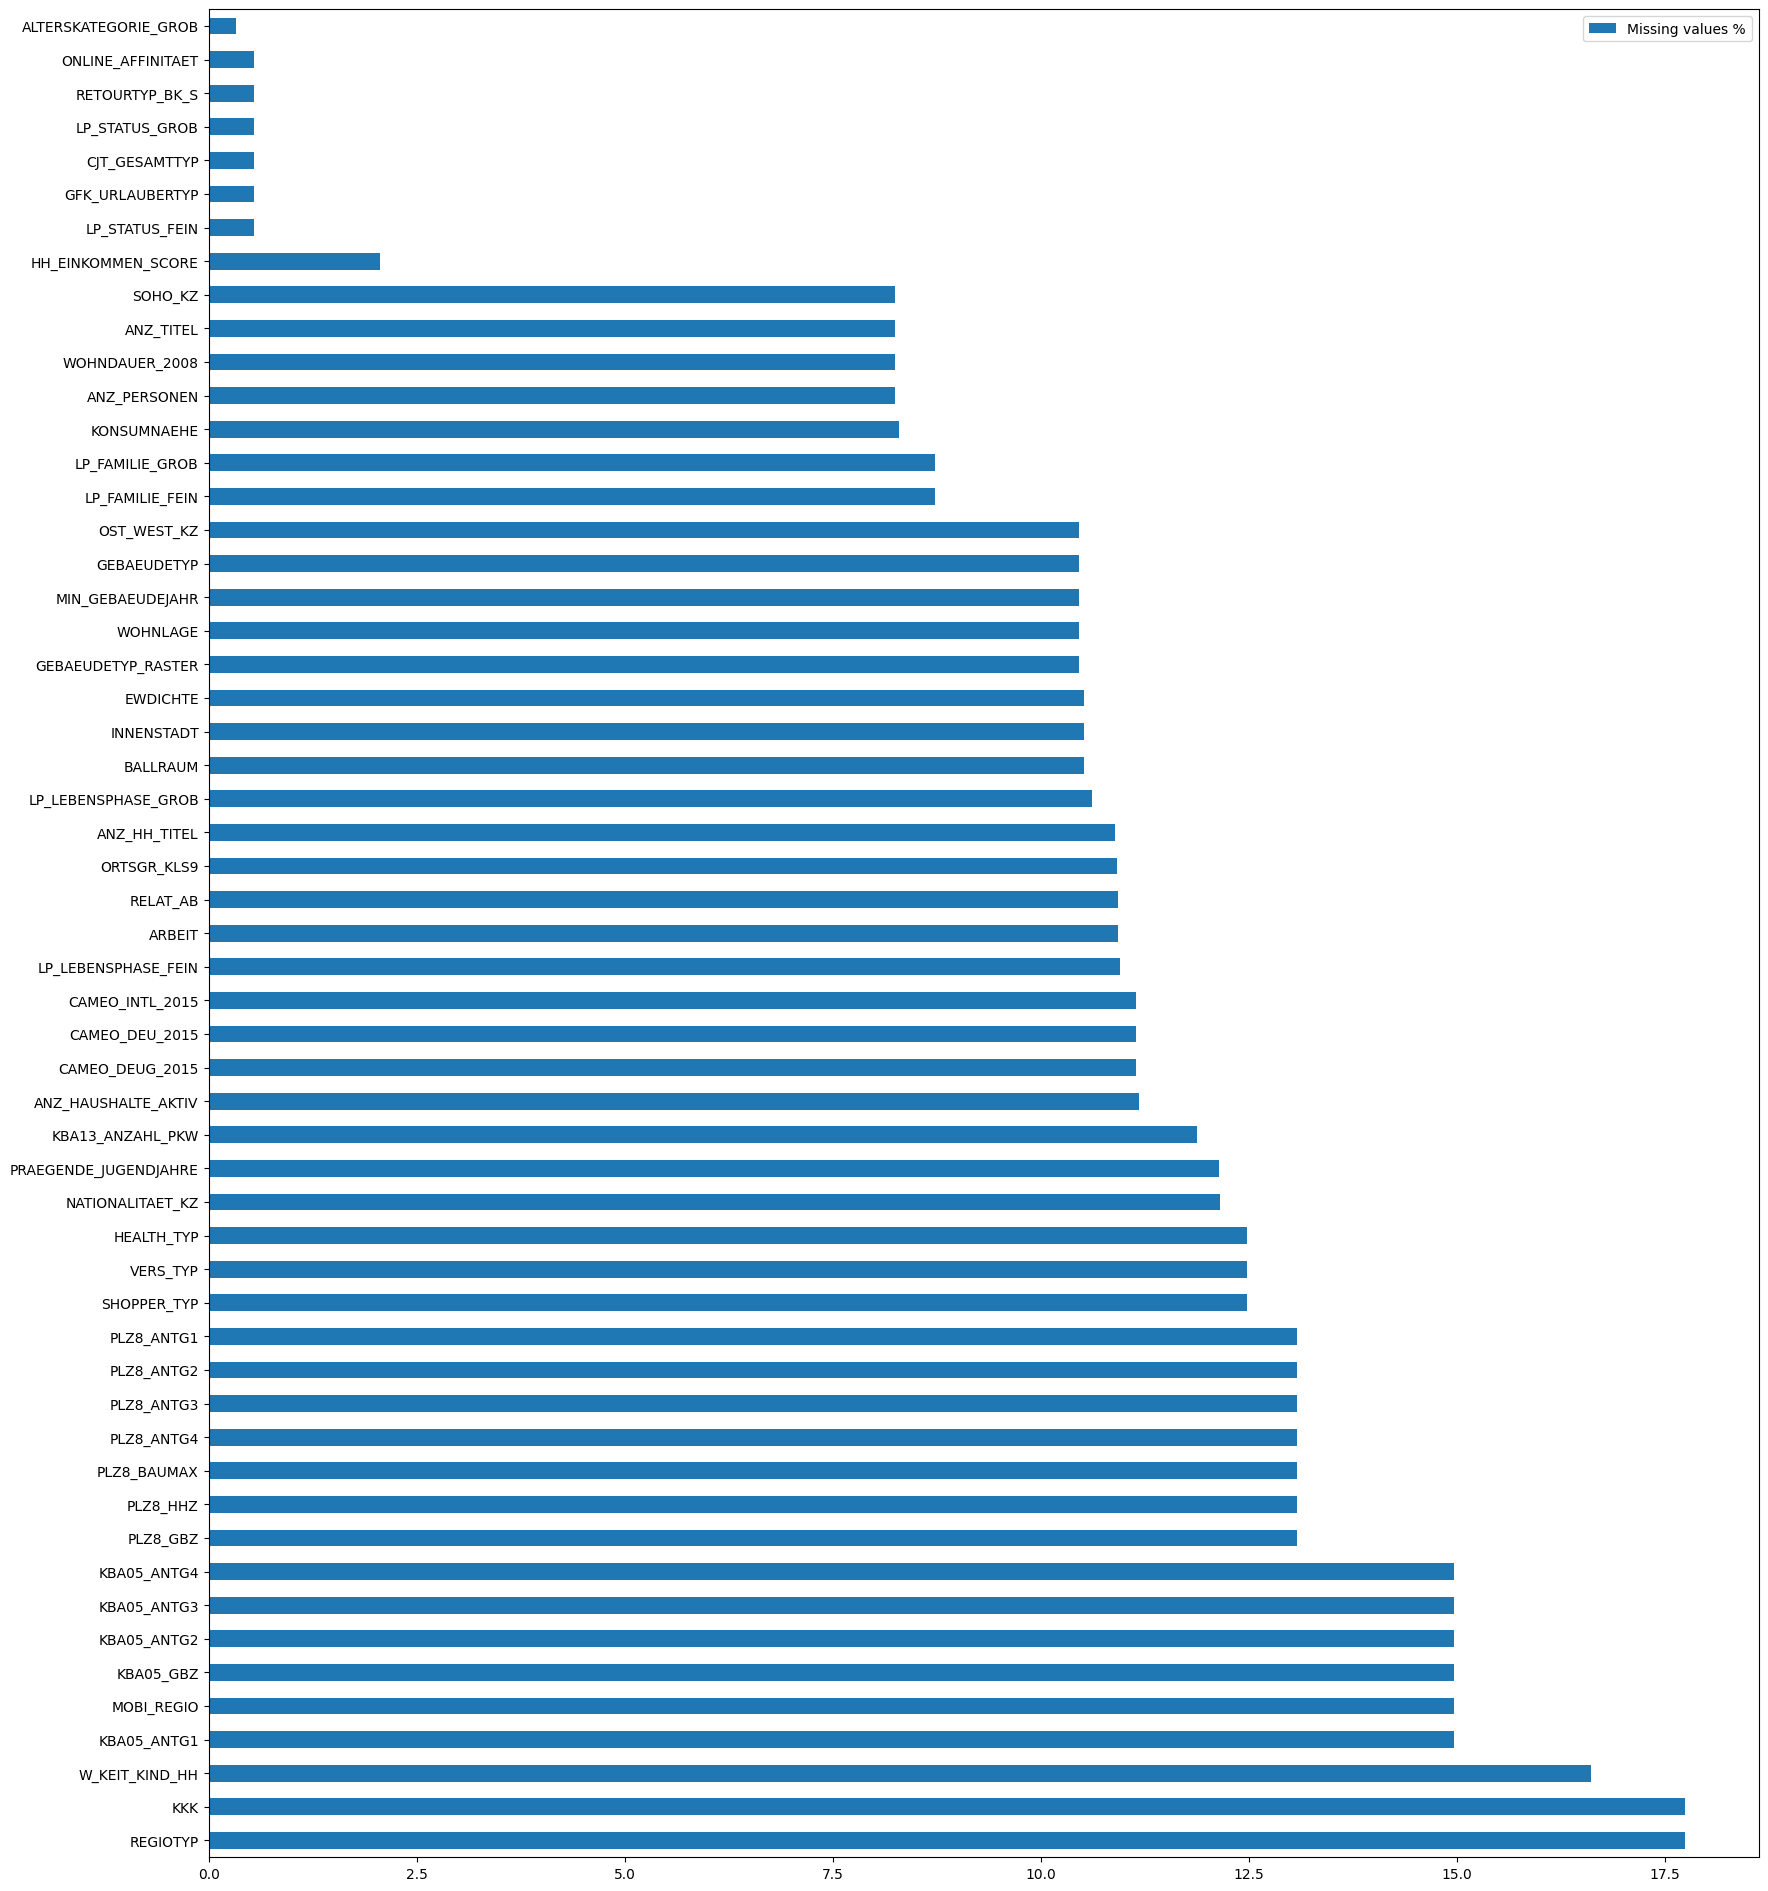

In [274]:
def plot_nas(df):
    if df.isnull().sum().sum() != 0:
        # find percentage
        nan_df = (df.isnull().sum() / len(df)) * 100    
        # remove non null values and sorting
        nan_df = nan_df.drop(nan_df[nan_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing values %' :nan_df})
        missing_data.plot(kind = "barh")
        plot_width, plot_height = (20,24)
        plt.rcParams['figure.figsize'] = (plot_width,plot_height)
        plt.show()
    else:
        print('No NAs found')
plot_nas(azdias)

In [319]:
azdias.iloc[0]

ALTERSKATEGORIE_GROB    2.0
ANREDE_KZ               1.0
CJT_GESAMTTYP           2.0
FINANZ_MINIMALIST       3.0
FINANZ_SPARER           4.0
                       ... 
PLZ8_HHZ                NaN
PLZ8_GBZ                NaN
ARBEIT                  NaN
ORTSGR_KLS9             NaN
RELAT_AB                NaN
Name: 0, Length: 79, dtype: object

In [380]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_max_nan = []
azdias_min_nan = []
type(azdias)
azdias_max_nan = azdias[azdias.isna().sum(axis=1) >= 5.649893797385833]
azdias_min_nan = azdias[azdias.isna().sum(axis=1) <= 5.649893797385833]
print(len(azdias_max_nan))
print(len(azdias_min_nan))
print(len(azdias_max_nan) + len(azdias_min_nan))
print(len(azdias))

# fig, (ax1, ax2) = plt.subplots(1, 2)
# sns.countplot(data=azdias_max_nan, x = azdias.columns[4], ax=ax1)
# sns.countplot(data=azdias_min_nan, x = azdias.columns[4], ax=ax2)
# ax1.set(xlabel='col_val', ylabel='count')
# ax2.set(xlabel='col_val', ylabel='count')
# plt.tight_layout()
# plt.show()

# removing the na
azdias_max_nan = azdias_max_nan.dropna(axis=1)
azdias_min_nan = azdias_min_nan.dropna(axis=1)
type(azdias_max_nan)

171597
719624
891221
891221


pandas.core.frame.DataFrame

In [382]:
azdias_max_nan.columns

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')

In [383]:
azdias_min_nan.columns

Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ZABEOTYP',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008',
       'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ'],
      dtype='object')

In [385]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# min_col_for_max_nan = azdias_max_nan.isna().sum(axis=0)
# min_col_for_min_nan = azdias_min_nan.isna().sum(axis=0)
# get columns present in both
common_col = azdias_max_nan.columns & azdias_min_nan.columns
print(common_col)


C:\Users\M1053229\AppData\Local\Temp\ipykernel_21412\2423521143.py:6: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  common_col = azdias_max_nan.columns & azdias_min_nan.columns


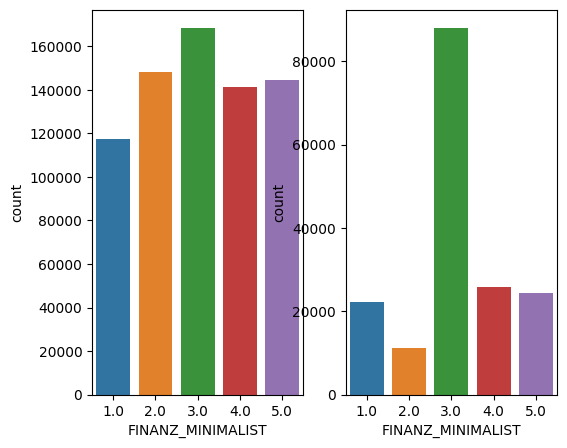

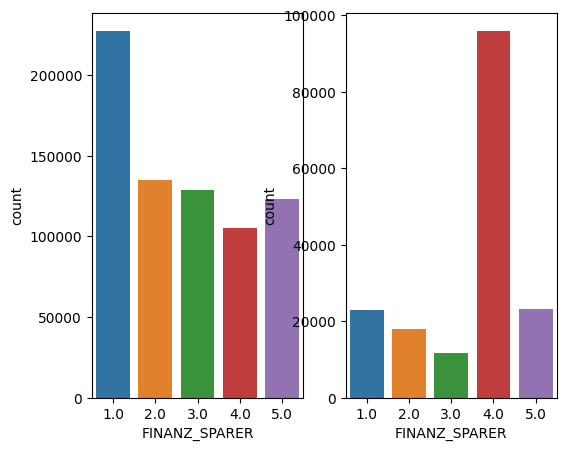

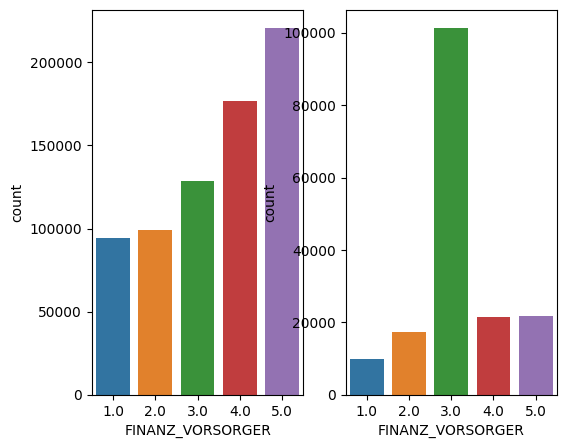

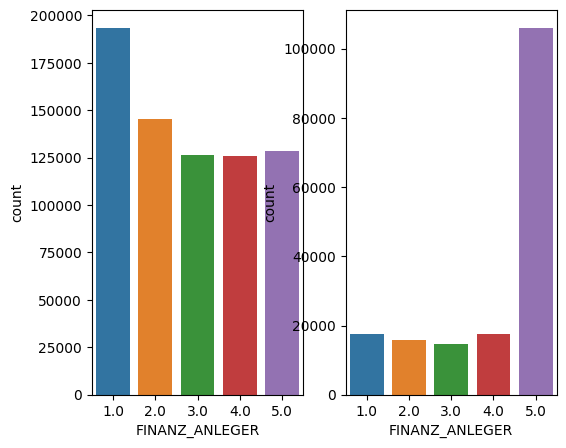

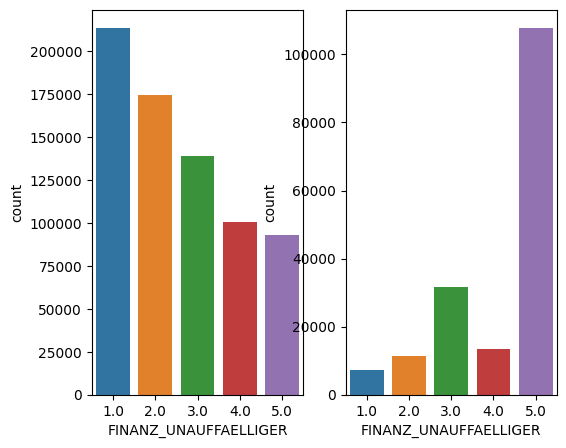

In [422]:
# def compare_distrubution(list_of_col):
for col in common_col[1:6]:
#     print(col)
      fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(6, 5), dpi=100)
      sns.countplot(data = azdias_min_nan, x= col, ax = axis1)
      sns.countplot(data = azdias_max_nan, x= col, ax=axis2)


In [423]:
type(azdias_min_nan['FINANZ_MINIMALIST'])

pandas.core.series.Series

#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on the observation of values and the chart, The values are significantly different in comparison. Eventhough, we skipped the values that are not nnull. I have removed the rows which are missing morethan 50% values from the set.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [475]:
# How many features are there of each data type?
# data_type_list = feat_info['type'].unique()
# print(data_type_list)
# feat_info.loc[(feat_info['type'] == 'numeric') & (~feat_info['attribute'].isin(['GEBURTSJAHR','ANZ_PERSONEN'])), 'attribute'].count()
# feat_info.loc[feat_info['type'] == 'numeric','attribute']


In [587]:
excluded_column = ["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"]
unique_type_list = feat_info['type'].unique()
def get_features_per_type(data_type_list):
    features_summary = []
    for val_data_type in data_type_list:
        val_count = feat_info.loc[feat_info['type'] == val_data_type, 'attribute'].count()
        val_count = feat_info.loc[(feat_info['type'] == val_data_type) & (~feat_info['attribute'].isin(excluded_column)), 'attribute'].count()
        features_summary.append({'val_type': val_data_type, 'val_count': val_count})
    return features_summary
    
custom_summary_data = get_features_per_type(unique_type_list)
# custom_summary_data

total_cs_count = 0
for index in range(len(custom_summary_data)):
    total_cs_count += int(custom_summary_data[index]['val_count'])
    print(custom_summary_data[index])
print(total_cs_count)


{'val_type': 'categorical', 'val_count': 18}
{'val_type': 'ordinal', 'val_count': 49}
{'val_type': 'numeric', 'val_count': 6}
{'val_type': 'mixed', 'val_count': 6}
{'val_type': 'interval', 'val_count': 0}
79


In [588]:
# feat_info.loc[feat_info['type'] == 'mixed','attribute'][0:6]

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [591]:
# removing row from feature summary set as well
feat_info.drop(feat_info[(feat_info['attribute'].isin(excluded_column))].index, inplace=True)

In [592]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
def get_classification_hint(col):
    val = pd.DataFrame(feat_info.loc[feat_info['type'] == col,'attribute'])
    for attr in val['attribute']:
        print(attr)
        print(azdias[attr].unique())
        print('---------------')

In [593]:
get_classification_hint('mixed')

LP_LEBENSPHASE_FEIN
[15. 21.  3.  0. 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.
  7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.
  9. 34. nan 40. 16. 17.]
---------------
LP_LEBENSPHASE_GROB
[ 4.  6.  1.  0. 10.  2.  3.  5.  7. 12. 11.  9.  8. nan]
---------------
PRAEGENDE_JUGENDJAHRE
[ 0 14 15  8  3 10 11  5  9  6  4  2  1 12 13  7]
---------------
WOHNLAGE
[nan  4.  2.  7.  3.  5.  1.  8.  0.]
---------------
CAMEO_INTL_2015
[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']
---------------
PLZ8_BAUMAX
[nan  1.  2.  4.  5.  3.]
---------------


In [594]:
get_classification_hint('categorical')

ANREDE_KZ
[1 2]
---------------
CJT_GESAMTTYP
[ 2.  5.  3.  4.  1.  6. nan]
---------------
FINANZTYP
[4 1 6 5 2 3]
---------------
GFK_URLAUBERTYP
[10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
---------------
GREEN_AVANTGARDE
[0 1]
---------------
LP_FAMILIE_FEIN
[ 2.  5.  1.  0. 10.  7. 11.  3.  8.  4.  6. nan  9.]
---------------
LP_FAMILIE_GROB
[ 2.  3.  1.  0.  5.  4. nan]
---------------
LP_STATUS_FEIN
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]
---------------
LP_STATUS_GROB
[ 1.  2.  4.  5.  3. nan]
---------------
NATIONALITAET_KZ
[0 1 3 2]
---------------
SHOPPER_TYP
[-1  3  2  1  0]
---------------
SOHO_KZ
[nan  1.  0.]
---------------
VERS_TYP
[-1  2  1]
---------------
ZABEOTYP
[3 5 4 1 6 2]
---------------
GEBAEUDETYP
[nan  8.  1.  3.  2.  6.  4.  5.]
---------------
OST_WEST_KZ
[nan 'W' 'O']
---------------
CAMEO_DEUG_2015
[nan '8' '4' '2' '6' '1' '9' '5' '7' '3' 'X']
---------------
CAMEO_DEU_2015
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B

In [616]:
# & (feat_info['attribute'].isin(['OST_WEST_KZ','CAMEO_DEU_2015']))
# df_categorical_encoded = pd.get_dummies(azdias, drop_first=True)
# df_categorical_encoded.head()
# categorical_columns['attribute']
az_categorical = azdias[categorical_columns['attribute']]
az_categorical_encoded = pd.get_dummies(az_categorical, drop_first=True)
az_categorical_encoded

#azdias1

In [634]:
# azdias = azdias.drop([az_categorical], axis=1)
azdias = pd.concat([azdias,az_categorical_encoded],axis=1)

In [635]:
azdias.shape

(798073, 129)

In [633]:
azdias1.shape

(798073, 78)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

From above, we can see that the column OST_WEST_KZ and CAMEO_DEU_2015 doesnt have the numerical values.OST_WEST_KZ has only two values, binary non numeric values and CAMEO_DEU_2015 has multi level categories which is also non numeric.

used dummies to generate the the encoding for the categorical values. I am not sure at this time have enough information to drop the data.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [558]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['PRAEGENDE_JUGENDJAHRE'].head()


0     NaN
1    14.0
2    15.0
3     8.0
4     8.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [559]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CAMEO_INTL_2015'].head()


0    NaN
1     51
2     24
3     12
4     43
Name: CAMEO_INTL_2015, dtype: object

In [596]:
def replace_engineer(list_val, conv_val, iter_val, iter_times):
    for i in range(iter_times):
        azdias[iter_val] = azdias[iter_val].replace(list_val[i],conv_val[i]) 


In [597]:
azdias['PRAEGENDE_JUGENDJAHRE_Movement'] = azdias['PRAEGENDE_JUGENDJAHRE'] 
azdias['PRAEGENDE_JUGENDJAHRE_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE'] 

azdias['PRAEGENDE_JUGENDJAHRE_Movement'] = azdias['PRAEGENDE_JUGENDJAHRE_Movement'].replace([1,3,5,8,10,12,14],0) 
azdias['PRAEGENDE_JUGENDJAHRE_Movement'] = azdias['PRAEGENDE_JUGENDJAHRE_Movement'].replace([2,4,6,7,9,11,13,15],1) 

#replace decades
azdias['PRAEGENDE_JUGENDJAHRE_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE_Decade'].replace([1,2], 40)
azdias['PRAEGENDE_JUGENDJAHRE_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE_Decade'].replace([3,4], 50)
azdias['PRAEGENDE_JUGENDJAHRE_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE_Decade'].replace([5,6,7], 60)
azdias['PRAEGENDE_JUGENDJAHRE_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE_Decade'].replace([8,9], 70)
azdias['PRAEGENDE_JUGENDJAHRE_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE_Decade'].replace([10,11, 12, 13], 80)
azdias['PRAEGENDE_JUGENDJAHRE_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE_Decade'].replace([14,15], 90)



,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade
0,2,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1,2,5.0,1,5,2,5,4,5,1,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,90
2,3,2,3.0,1,4,1,2,3,5,1,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1,90
3,4,2,2.0,4,2,5,2,1,2,6,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,70
4,3,1,5.0,4,3,4,1,3,2,5,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3,2,5.0,1,4,2,5,4,4,1,...,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN,0,90
891217,2,1,4.0,3,3,3,2,2,3,6,...,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0,0,80
891218,2,2,4.0,2,4,2,5,4,3,1,...,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0,0,90
891219,1,1,3.0,1,5,3,5,5,5,1,...,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0,0,90


In [608]:
azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)

In [657]:
#azdias['CAMEO_INTL_2015_Wealth'] = backup['CAMEO_INTL_2015'] 
#azdias['CAMEO_INTL_2015_Lifestyle'] = backup['CAMEO_INTL_2015'] 

azdias['CAMEO_INTL_2015_Wealth'] = azdias['CAMEO_INTL_2015_Wealth'].replace(["11","12",'13','14','15'],1) 
azdias['CAMEO_INTL_2015_Wealth'] = azdias['CAMEO_INTL_2015_Wealth'].replace(['21','22','23','24','25'],2) 
azdias['CAMEO_INTL_2015_Wealth'] = azdias['CAMEO_INTL_2015_Wealth'].replace(['31','32','33','34','35'],3) 
azdias['CAMEO_INTL_2015_Wealth'] = azdias['CAMEO_INTL_2015_Wealth'].replace(['41','42','43','44','45'],4) 
azdias['CAMEO_INTL_2015_Wealth'] = azdias['CAMEO_INTL_2015_Wealth'].replace(['51','52','53','54','55'],5) 


azdias['CAMEO_INTL_2015_Lifestyle'] = azdias['CAMEO_INTL_2015_Lifestyle'].replace(['11','21','31','41','51'], 1)
azdias['CAMEO_INTL_2015_Lifestyle'] = azdias['CAMEO_INTL_2015_Lifestyle'].replace(['12','22','32','42','52'], 2)
azdias['CAMEO_INTL_2015_Lifestyle'] = azdias['CAMEO_INTL_2015_Lifestyle'].replace(['13','23','33','43','53'], 3)
azdias['CAMEO_INTL_2015_Lifestyle'] = azdias['CAMEO_INTL_2015_Lifestyle'].replace(['14','24','34','44','54'], 4)
azdias['CAMEO_INTL_2015_Lifestyle'] = azdias['CAMEO_INTL_2015_Lifestyle'].replace(['15','25','35','45','55'], 5)

#azdias = azdias.drop(['CAMEO_INTL_2015'], axis=1)


#### Discussion 1.2.2: Engineer Mixed-Type Features

I performed replace items as mentioned in the description, replace/add new columns. but however I wonder generally we would one hot encoding for these things if we needed to properly distributed but this time we had performed the manual way is there any specific reason for this excercise?

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [601]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# removing further more columns which are greater than 15%
#azdias = azdias.drop(["W_KEIT_KIND_HH", "KKK", "REGIOTYP"], axis=1)

# based on reading the data, I understand I might have to remove the missing data rows that are greater than 30%
azdias.drop(azdias[azdias.isna().sum(axis=1)> 30].index, inplace=True)

In [602]:
azdias.shape

(798073, 80)

In [658]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.select_dtypes(exclude=["float", 'int','uint8'])


""
1
2
3
4
5
...
891216
891217
891218
891219


In [646]:
azdias['CAMEO_INTL_2015_Wealth'] = azdias['CAMEO_INTL_2015_Wealth'].replace(['XX'], np.nan)
azdias['CAMEO_INTL_2015_Lifestyle'] = azdias['CAMEO_INTL_2015_Lifestyle'].replace(['XX'], np.nan)


In [650]:
#check the cause
azdias['CAMEO_INTL_2015_Lifestyle'].unique()


array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [659]:
# check the missing values and then encode the non numeric values if required else drop.
# all the values are validated that it doesnt have any non numeric data with them.
azdias.select_dtypes(exclude=["float", 'int','uint8'])

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [2]:
#Helpers

# convert the string array values to array
def convert_to_list(input_val):
    result = []
    str_val = input_val.strip('][').split(',')
    for val in str_val:
        try:
            result.append(int(val))
        except:
            result.append(val)
    return result

# validate against the missing columns on the feature summary
def get_known_missing_value(colname, index, feat_info):
    string_value = feat_info.loc[feat_info['attribute'] == colname, 'missing_or_unknown'][index]
    if(string_value == '[]'):
        return []
    return convert_to_list(string_value)

# Identify missing or unknown data values and convert them to NaNs.
def replace_missing_val_with_nan(df, feat_info):
    i = 0
    for (index, colname) in enumerate(df):
        missing_values = get_known_missing_value(colname, i, feat_info)
        df.loc[df[colname].isin(missing_values), colname] = np.nan
        i+=1
        
# sort the missing value columns
def get_missing_val_col_gt_15(df):
    col_to_remove =[]
    for (index, colname) in enumerate(df):
        # add column if there are more than 15% missing values
        if(((df[colname].isna().sum()/len(df))*100) > 15):
            col_to_remove.append(colname)
    return col_to_remove

#remove rows that have more than 25% missing data
def remove_rows_gt_25(df):
    print('--row count with > 30')
    print(df[df.isna().sum(axis=1)> 30].count())
    df.drop(df[df.isna().sum(axis=1)> 30].index, inplace=True)
    
#get the categorical column
def get_categorical_col(df,feat_info):
    cat_col = []
    val = pd.DataFrame(feat_info.loc[feat_info['type'] == 'categorical','attribute'])
    for attr in val['attribute']:
        cat_col.append(attr)
    print('--cat col--')
    print(cat_col)
    return cat_col

#encode the categorical column
def encode_categorical_col(df, feat_info):
    cat_col = get_categorical_col(df, feat_info)
    df_categorical = df[cat_col]
    df_categorical_encoded = pd.get_dummies(df_categorical, drop_first=True)
    print('--encoded shape--')
    print(df_categorical_encoded.shape)
    print('--before merge--')
    print(df.shape)
    # remove base column
    df = df.drop(cat_col, axis=1)
    print('dropping col')
    # adding the encoded the column back
    df = pd.concat([df,df_categorical_encoded],axis=1)
    print('--after merge')
    print(df.shape)
    return df
    
# replace and engineer the said data
def replace_engineer_PJ(df):
    df['PRAEGENDE_JUGENDJAHRE_Movement'] = df['PRAEGENDE_JUGENDJAHRE'] 
    df['PRAEGENDE_JUGENDJAHRE_Decade'] = df['PRAEGENDE_JUGENDJAHRE'] 
    df['PRAEGENDE_JUGENDJAHRE_Movement'] = df['PRAEGENDE_JUGENDJAHRE_Movement'].replace([1,3,5,8,10,12,14],0) 
    df['PRAEGENDE_JUGENDJAHRE_Movement'] = df['PRAEGENDE_JUGENDJAHRE_Movement'].replace([2,4,6,7,9,11,13,15],1) 

    #replace decades
    df['PRAEGENDE_JUGENDJAHRE_Decade'] = df['PRAEGENDE_JUGENDJAHRE_Decade'].replace([1,2], 40)
    df['PRAEGENDE_JUGENDJAHRE_Decade'] = df['PRAEGENDE_JUGENDJAHRE_Decade'].replace([3,4], 50)
    df['PRAEGENDE_JUGENDJAHRE_Decade'] = df['PRAEGENDE_JUGENDJAHRE_Decade'].replace([5,6,7], 60)
    df['PRAEGENDE_JUGENDJAHRE_Decade'] = df['PRAEGENDE_JUGENDJAHRE_Decade'].replace([8,9], 70)
    df['PRAEGENDE_JUGENDJAHRE_Decade'] = df['PRAEGENDE_JUGENDJAHRE_Decade'].replace([10,11, 12, 13], 80)
    df['PRAEGENDE_JUGENDJAHRE_Decade'] = df['PRAEGENDE_JUGENDJAHRE_Decade'].replace([14,15], 90)
    
    #drop the column
    df = df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    return df
    
def replace_engineer_CI2015(df):
    df['CAMEO_INTL_2015_Wealth'] = df['CAMEO_INTL_2015'] 
    df['CAMEO_INTL_2015_Lifestyle'] = df['CAMEO_INTL_2015'] 
    df['CAMEO_INTL_2015_Wealth'] = df['CAMEO_INTL_2015_Wealth'].replace(["11","12",'13','14','15'],1) 
    df['CAMEO_INTL_2015_Wealth'] = df['CAMEO_INTL_2015_Wealth'].replace(['21','22','23','24','25'],2) 
    df['CAMEO_INTL_2015_Wealth'] = df['CAMEO_INTL_2015_Wealth'].replace(['31','32','33','34','35'],3) 
    df['CAMEO_INTL_2015_Wealth'] = df['CAMEO_INTL_2015_Wealth'].replace(['41','42','43','44','45'],4) 
    df['CAMEO_INTL_2015_Wealth'] = df['CAMEO_INTL_2015_Wealth'].replace(['51','52','53','54','55'],5) 


    df['CAMEO_INTL_2015_Lifestyle'] = df['CAMEO_INTL_2015_Lifestyle'].replace(['11','21','31','41','51'], 1)
    df['CAMEO_INTL_2015_Lifestyle'] = df['CAMEO_INTL_2015_Lifestyle'].replace(['12','22','32','42','52'], 2)
    df['CAMEO_INTL_2015_Lifestyle'] = df['CAMEO_INTL_2015_Lifestyle'].replace(['13','23','33','43','53'], 3)
    df['CAMEO_INTL_2015_Lifestyle'] = df['CAMEO_INTL_2015_Lifestyle'].replace(['14','24','34','44','54'], 4)
    df['CAMEO_INTL_2015_Lifestyle'] = df['CAMEO_INTL_2015_Lifestyle'].replace(['15','25','35','45','55'], 5)
    
    df['CAMEO_INTL_2015_Wealth'] = df['CAMEO_INTL_2015_Wealth'].replace(['XX'], np.nan)
    df['CAMEO_INTL_2015_Lifestyle'] = df['CAMEO_INTL_2015_Lifestyle'].replace(['XX'], np.nan)
    
    #drop the original column
    df = df.drop(['CAMEO_INTL_2015'], axis=1)
    return df
    
def re_engineer(df):
    df = replace_engineer_PJ(df)
    df = replace_engineer_CI2015(df)
    return df

In [3]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    replace_missing_val_with_nan(df, feat_info)
    
    # remove selected columns 
    col_list = get_missing_val_col_gt_15(df)
    df = df.drop(col_list, axis=1)
    
    indexes = feat_info[ (feat_info['attribute'].isin(col_list))].index
    feat_info.drop(indexes, inplace=True)
    
    #remove selected columns and rows
    remove_rows_gt_25(df)
    
    # select, re-encode, and engineer column values.
    df = encode_categorical_col(df, feat_info)
    df = re_engineer(df)
    # Return the cleaned dataframe.
    
    invalid_col = df.select_dtypes(exclude=["float", 'int','uint8'])
    if(len(invalid_col.columns) > 0):
        print('still strings are present')
    else:
        print('encoding successful')
    
    return df
    

In [4]:
# Load in the general demographics data.
test = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
tes_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [5]:
cleaned_ds = clean_data(test, tes_info)

--row count with > 30
ALTERSKATEGORIE_GROB    92591
ANREDE_KZ               92669
CJT_GESAMTTYP           92567
FINANZ_MINIMALIST       92669
FINANZ_SPARER           92669
                        ...  
PLZ8_HHZ                    0
PLZ8_GBZ                    0
ARBEIT                      2
ORTSGR_KLS9                 2
RELAT_AB                    2
Length: 76, dtype: int64
--cat col--
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
--encoded shape--
(798552, 67)
--before merge--
(798552, 76)
dropping col
--after merge
(798552, 125)
encoding successful


In [6]:
cleaned_ds.shape

(798552, 127)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [7]:
total_nan_percent = cleaned_ds.isnull().sum().sum()/len(cleaned_ds)
print(total_nan_percent)

1.0786824151714602


In [8]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.impute import SimpleImputer
 
imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='mean')

imputer = imputer.fit(cleaned_ds)

transformed_data = imputer.transform(cleaned_ds)

In [9]:
transformed_data

array([[ 1.,  1.,  5., ..., 90.,  5.,  1.],
       [ 3.,  1.,  4., ..., 90.,  2.,  4.],
       [ 4.,  4.,  2., ..., 70.,  1.,  2.],
       ...,
       [ 2.,  2.,  4., ..., 90.,  2.,  4.],
       [ 1.,  1.,  5., ..., 90.,  5.,  1.],
       [ 4.,  4.,  2., ..., 50.,  4.,  3.]])

In [10]:
# Apply feature scaling to the general population demographics data.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

transform_scalar = StandardScaler().fit_transform(transformed_data)




In [11]:
transform_scalar.shape

(798552, 127)

### Discussion 2.1: Apply Feature Scaling

We have a total of 1.07% of nan values available in the dataset. For the imupter function since its less than one percent I wanted to explore the imputer for both the mean and most_frequent used values

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [12]:
#Helpers

def screen_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

In [13]:
# Apply PCA to the data.
# without any n_components
pca = PCA()
pca_transformed = pca.fit_transform(transform_scalar)


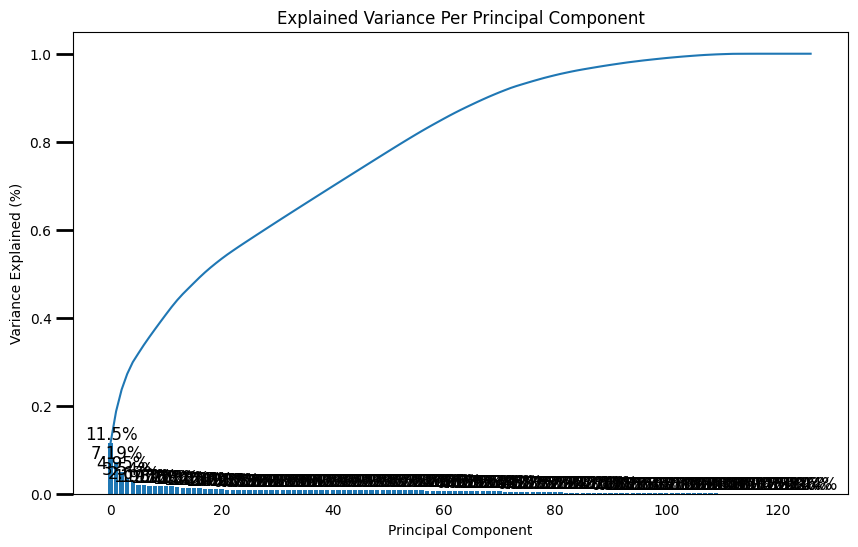

In [14]:
screen_plot(pca)

In [15]:
pca.explained_variance_ratio_[126] * 100

5.4419376747991254e-30

In [87]:
# Investigate the variance accounted for by each principal component.
for val in len(pca.explained_variance_ratio_):
    if(pca.explained_variance_ratio_[val] * 100 >)


127

In [16]:
np.cumsum(pca.explained_variance_ratio_[:20])[-1] * 100

52.42991369701543

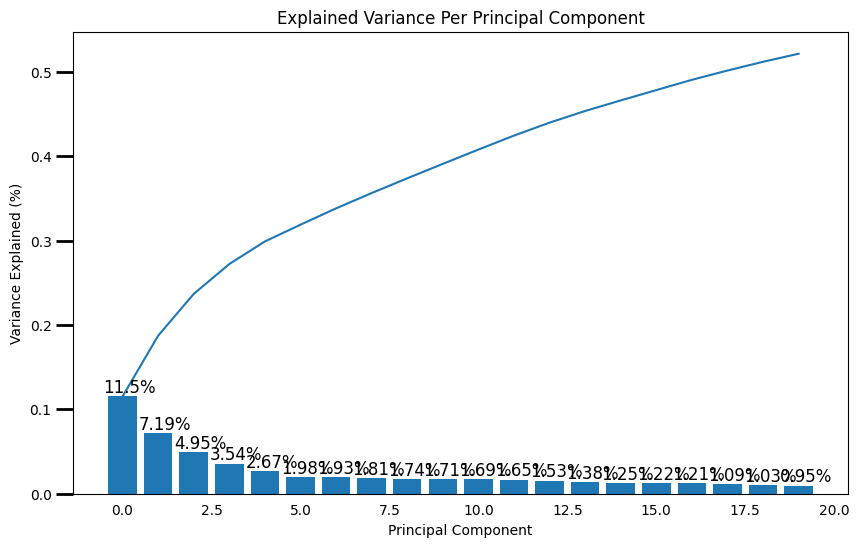

In [17]:
# Re-apply PCA to the data while selecting for number of components to retain.
finalPCA = PCA(n_components=20)
pca_transformed = finalPCA.fit_transform(transform_scalar)
screen_plot(finalPCA)

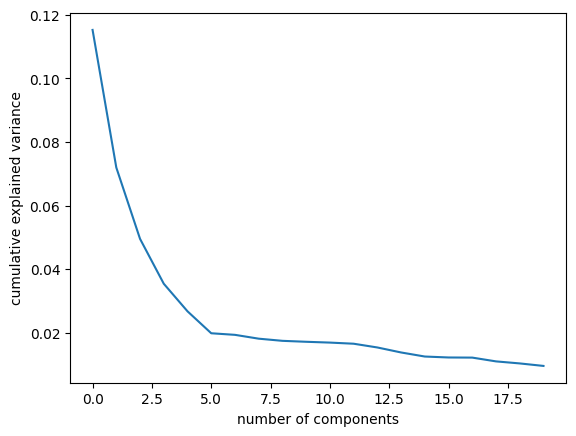

In [18]:
plt.plot(finalPCA.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

After the analysis we can see from the above graph and the cumulative percentage the values seems to be not moving much post 20 components. and the total number of features its revealing is 52.23%. so I will move with 20 components fo further processing.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [162]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# finalPCA.components_
# len(finalPCA.components_[0])

def map_weights(pca, feature_index, original_cleaned_ds):
    closer_to_1 = []
    closer_to_0 = []
    feat = pd.DataFrame(pca.components_, columns = original_cleaned_ds.columns)
    weights = feat.iloc[feature_index].sort_values(ascending=0)
    return weights
    
#     for i in len(weights):
#         if(weights[i] > 0):
#             closer_to_1.append()
#     print(weights)
#     closer_to_1 = weights[weights > 0].sort_values(ascending=0)
#     farther_to_1 =weights[weights < 0].sort_values(ascending=1)
#     return closer_to_1[:5], farther_to_1[:5]


In [163]:
# closer_to_1, closer_to_0 = map_weights(finalPCA, 0, cleaned_ds)
map_weights(finalPCA, 0, cleaned_ds)


PLZ8_ANTG3                0.194580
CAMEO_INTL_2015_Wealth    0.191832
PLZ8_ANTG4                0.188679
HH_EINKOMMEN_SCORE        0.187371
PLZ8_BAUMAX               0.184186
                            ...   
PLZ8_ANTG1               -0.195248
KBA05_ANTG1              -0.198711
LP_STATUS_GROB           -0.205924
LP_STATUS_FEIN           -0.208773
MOBI_REGIO               -0.212577
Name: 0, Length: 127, dtype: float64

In [165]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(finalPCA, 1, cleaned_ds)


ALTERSKATEGORIE_GROB            0.267896
FINANZ_VORSORGER                0.239131
SEMIO_ERL                       0.227613
SEMIO_LUST                      0.185676
RETOURTYP_BK_S                  0.162051
                                  ...   
SEMIO_TRADV                    -0.234506
SEMIO_PFLICHT                  -0.236966
FINANZ_SPARER                  -0.250828
PRAEGENDE_JUGENDJAHRE_Decade   -0.256894
SEMIO_REL                      -0.259819
Name: 1, Length: 127, dtype: float64

In [166]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(finalPCA, 3, cleaned_ds)


LP_FAMILIE_GROB        0.331369
LP_FAMILIE_FEIN        0.329290
LP_LEBENSPHASE_GROB    0.322626
LP_LEBENSPHASE_FEIN    0.315688
ANZ_PERSONEN           0.278846
                         ...   
KONSUMNAEHE           -0.103418
HH_EINKOMMEN_SCORE    -0.126112
BALLRAUM              -0.163245
WOHNLAGE              -0.170549
INNENSTADT            -0.171687
Name: 3, Length: 127, dtype: float64

### Discussion 2.3: Interpret Principal Components

Fisrt Principal component has the positive position on PLZ8_ANTG3,CAMEO_INTL_2015_Wealth,PLZ8_ANTG4,HH_EINKOMMEN_SCORE, PLZ8_BAUMAX which primary focusing on gather information about House Sizing, wealth, housing in a particular region, household  income, higher common building own. In summary, most of the data which has positive incomes has house and wealth involved.

First Principal component has the negative positin on PLZ8_ANTG1,KBA05_ANTG1,LP_STATUS_GROB,LP_STATUS_FEIN,MOBI_REGIO which focuses on houses on another region,  housing, social status and movement patterns.

Second principal component has the positive position on columns ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, SEMIO_ERL, SEMIO_LUST, RETOURTYP_BK_S which primarily focuses about agegroup, finance situation, personality type and shopping identification.

Second principal component negatively directing on SEMIO_TRADV, SEMIO_PFLICHT, FINANZ_SPARER, PRAEGENDE_JUGENDJAHRE_Decade,
SEMIO_REL which focuses on personality, finance topology, movement and personality. In summary it negatively directed towards the personality and finance topology.

Third principal component has the positive position on columns LP_FAMILIE_GROB, LP_FAMILIE_FEIN, LP_LEBENSPHASE_GROB, LP_LEBENSPHASE_FEIN, ANZ_PERSONEN which primarily focuses about agegroup, lifestyle, life stage, family type.

Third principal component negatively directing on KONSUMNAEHE, HH_EINKOMMEN_SCORE, BALLRAUM, WOHNLAGE,
INNENSTADT which focuses on distance from the city center/urban center/PoS, neighbourhood quality, net income.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [70]:
   # Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
def run_kmeans(data, clusters):
    kmeans = KMeans(n_clusters=clusters)
    model = kmeans.fit(data)
    labels = model.predict(data)
    score = np.abs(model.score(data))
    return labels, score


In [73]:
# as per suggestion running to max 20 and initializing it with 3
clustering_details = []
scores = []
for i in range(3, 25):
    labels, score = run_kmeans(pca_transformed, i)
    clustering_details.append({'cluster_num': i, 'labels': labels, 'score': score})
    scores.append(score)


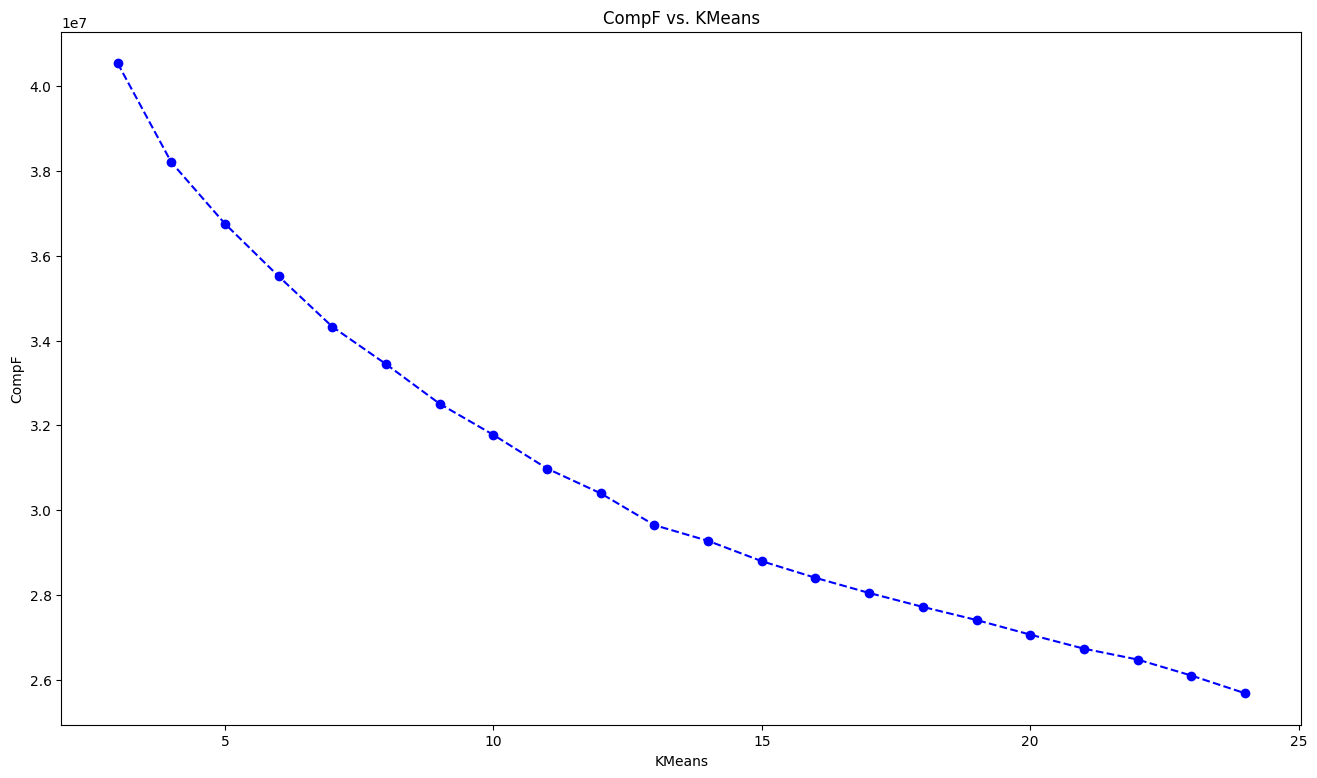

In [74]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

centers = list(range(3,25))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('KMeans');
plt.ylabel('CompF');
plt.title('CompF vs. KMeans');


In [76]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

labels, scores = run_kmeans(pca_transformed, 24)

In [78]:
print(labels.shape)
print(scores)

(798552,)
25657996.04348985


### Discussion 3.1: Apply Clustering to General Population

I was running the Identification of KMeans for the PCA transformed data starting from 3 clusters upto 24. It seems to be parabolic and doesnt seems like it goes down drastically. May be after 24 it might face lesser changes. so, I am keeping 24 clusters in the given data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [99]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
feat_summary_cust = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
print(feat_summary_cust.shape)
print(customers.shape)
print(azdias.shape)

(85, 4)
(191652, 85)
(891221, 85)


In [100]:
replace_missing_val_with_nan(azdias, feat_summary_cust)
replace_missing_val_with_nan(customers, feat_summary_cust)

In [104]:
col_list_az = get_missing_val_col_gt_15(azdias)
col_list_cust = get_missing_val_col_gt_15(customers)

print(len(col_list_az))
print(len(col_list_cust))

9
53


--row count with > 30
ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
CJT_GESAMTTYP            0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GFK_URLAUBERTYP          0
GREEN_AVANTGARDE         0
LP_STATUS_FEIN           0
LP_STATUS_GROB           0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
HH_EINKOMMEN_SCORE       0
ONLINE_AFFINITAET        0
dtype: int64
--cat col--
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_ST

KeyError: 'PRAEGENDE_JUGENDJAHRE'

In [ ]:
PRAEGENDE_JUGENDJAHRE_Movement

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.